In [15]:
import os
import pandas as pd
import time
import torch
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torchaudio.transforms import MelSpectrogram
import random
import matplotlib.pyplot as plt
from google.colab import drive
import torchvision.models as models
import librosa

drive.mount('/content/gdrive')
if not os.path.exists("/content/UrbanSound8K/"):
    !unzip -q /content/gdrive/MyDrive/UrbanSound8K.zip
root_dir = '/content/UrbanSound8K/audio'
data_dir = root_dir + '/fold1'
training_dir = root_dir + '/training'
test_dir = root_dir + '/test'

csv_file = '/content/UrbanSound8k/metadata/UrbanSound8k.csv'

label_mapping = {
    'air_conditioner': 0,
    'car_horn': 1,
    'children_playing': 2,
    'dog_bark': 3,
    'drilling': 4,
    'engine_idling': 5,
    'gun_shot': 6,
    'jackhammer': 7,
    'siren': 8,
    'street_music': 9
    # Add more labels as needed
}


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
def split_files(source_folder, dest_folder1, dest_folder2, split_ratio):
    # Ensure the destination folders exist
    os.makedirs(dest_folder1, exist_ok=True)
    os.makedirs(dest_folder2, exist_ok=True)

    # Get a list of all files in the source folder
    files = os.listdir(source_folder)
    num_files = len(files)

    # Calculate the number of files to move to each destination folder
    num_files1 = int(num_files * split_ratio)
    num_files2 = num_files - num_files1

    # Shuffle the list of files randomly
    random.seed(42)
    random.shuffle(files)

    # Move files to destination folders based on the split ratio
    for i, filename in enumerate(files):
        source_path = os.path.join(source_folder, filename)
        if i < num_files1:
            dest_path = os.path.join(dest_folder1, filename)
        else:
            dest_path = os.path.join(dest_folder2, filename)
        shutil.move(source_path, dest_path)

split_files(data_dir, training_dir, test_dir, 0.9)


In [17]:

# Hyperparameters
num_epochs = 16
learning_rate = 0.001
batch_size = 4

def create_spectrogram(audio):
    waveform, sample_rate = torchaudio.load(audio)
    mel_spectrogram = MelSpectrogram()(waveform)

    to_pil_image = transforms.ToPILImage()
    mel_spectrogram = to_pil_image(mel_spectrogram)
    return mel_spectrogram


class CustomDataset(Dataset):
    def __init__(self, data_dir, csv_file, transform):
        self.data = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.transform = transform
        audio_item = os.path.join(self.data_dir, self.data['slice_file_name'].iloc[1])


    def __len__(self):
        items = os.listdir(self.data_dir)
        return len(items)

    def __getitem__(self, idx):
        audio_item = os.path.join(self.data_dir, self.data['slice_file_name'].iloc[idx])  # Get the file path from CSV
        if not os.path.exists(audio_item):
            # You can add some error handling or logging here if needed
            return None

        spectrogram = create_spectrogram(audio_item)
        spectrogram = spectrogram.convert('RGB')
        spectrogram = self.transform(spectrogram)

        str_label = self.data['class'].iloc[idx]
        label = label_mapping[str_label]

        return spectrogram, label



In [18]:
# AlexNet model
alexNetModel = models.alexnet(pretrained=True)
alexNetModel = torch.nn.Sequential(
    alexNetModel,
    torch.nn.Linear(1000,10)
)
alexNetModel=alexNetModel.cuda()
alexNetoptimizer = optim.SGD(alexNetModel.parameters(), lr=learning_rate, momentum=0.9)

# VGG19 model
vgg11Model = models.vgg11(pretrained=True)
vgg11Model = torch.nn.Sequential(
    vgg11Model,
    torch.nn.Linear(1000,10)
)
vgg11Model=vgg11Model.cuda()
vgg11optimizer = optim.SGD(vgg11Model.parameters(), lr=learning_rate, momentum=0.9)

# ResNet50 model
resNet50Model = models.resnet50(pretrained=True)
resNet50Model = torch.nn.Sequential(
    resNet50Model,
    torch.nn.Linear(1000,10)
)
resNet50Model=resNet50Model.cuda()
resNet50optimizer = optim.SGD(resNet50Model.parameters(), lr=learning_rate, momentum=0.9)

# DenseNet121 model
densenetModel = models.densenet121(pretrained=True)
densenetModel = torch.nn.Sequential(
    densenetModel,
    torch.nn.Linear(1000,10)
)
densenetModel=densenetModel.cuda()
densenetOptimizer = optim.SGD(densenetModel.parameters(), lr=learning_rate, momentum=0.9)


criterion = nn.CrossEntropyLoss()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
def define_dataset(batch_size = 4, full_set = False):
    if not full_set:
        train_dataset = CustomDataset(training_dir, csv_file, transform=transform)
        test_dataset = CustomDataset(test_dir, csv_file, transform=transform)
    else:
        train_dataset = CustomDataset(training_dir_full, csv_file, transform=transform)
        test_dataset = CustomDataset(test_dir_full, csv_file, transform=transform)
    train_dataset = [entry for entry in train_dataset if entry is not None]
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_dataset = [entry for entry in test_dataset if entry is not None]
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

    return train_loader, test_loader


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  w

In [19]:
def train_model(model, optimizer, criterion, num_epochs, batch_size = 4, learning_rate = 0.001, full_set = False):
    start_time = time.time()
    train_loader, test_loader = define_dataset(batch_size = batch_size, full_set=full_set)
    train_accuracy_values = []  # List to store accuracy values for each epoch
    train_loss_values = []
    val_accuracy_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:

            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        accuracy = 100 * correct / total
        train_accuracy_values.append(accuracy)  # Append the accuracy to the list
        train_loss_values.append(running_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

        correct = 0
        total = 0

        for inputs, labels in test_loader:
            # Disable gradient calculation
            with torch.no_grad():

                inputs = inputs.cuda()
                labels = labels.cuda()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        accuracy = 100 * correct / total
        val_accuracy_values.append(accuracy)  # Append the accuracy to the list
        val_loss_values.append(running_loss)

        torch.cuda.empty_cache()

    num_epochs = len(train_accuracy_values)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Plot training accuracy
    axes[0, 0].plot(range(1, num_epochs + 1), train_accuracy_values)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].set_title('Training Accuracy vs. Epoch')

    # Plot training loss
    axes[0, 1].plot(range(1, num_epochs + 1), train_loss_values)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Training Loss vs. Epoch')

    # Plot validation accuracy
    axes[1, 0].plot(range(1, num_epochs + 1), val_accuracy_values)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Test Accuracy vs. Epoch')

    # Plot validation loss
    axes[1, 1].plot(range(1, num_epochs + 1), val_loss_values)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Test Loss vs. Epoch')

    fig.suptitle(f'Training and Validation Metrics\nLearning Rate: {learning_rate}, Batch Size: {batch_size}', fontsize=16)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the entire subplot
    plt.show()
    print('Finished Training')
    print(f'Final test accuracy = {accuracy:.2f}%')
    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time



/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.2525, Accuracy: 18.98%
Epoch 2/16, Loss: 1.9387, Accuracy: 30.06%
Epoch 3/16, Loss: 1.7056, Accuracy: 37.58%
Epoch 4/16, Loss: 1.5693, Accuracy: 41.66%
Epoch 5/16, Loss: 1.3460, Accuracy: 49.04%
Epoch 6/16, Loss: 1.2727, Accuracy: 57.45%
Epoch 7/16, Loss: 1.2347, Accuracy: 57.83%
Epoch 8/16, Loss: 1.0941, Accuracy: 60.51%
Epoch 9/16, Loss: 0.9890, Accuracy: 65.48%
Epoch 10/16, Loss: 1.0469, Accuracy: 63.31%
Epoch 11/16, Loss: 0.8472, Accuracy: 70.06%
Epoch 12/16, Loss: 0.6680, Accuracy: 75.16%
Epoch 13/16, Loss: 0.9566, Accuracy: 67.39%
Epoch 14/16, Loss: 0.7984, Accuracy: 70.45%
Epoch 15/16, Loss: 0.6962, Accuracy: 75.67%
Epoch 16/16, Loss: 0.6376, Accuracy: 76.43%


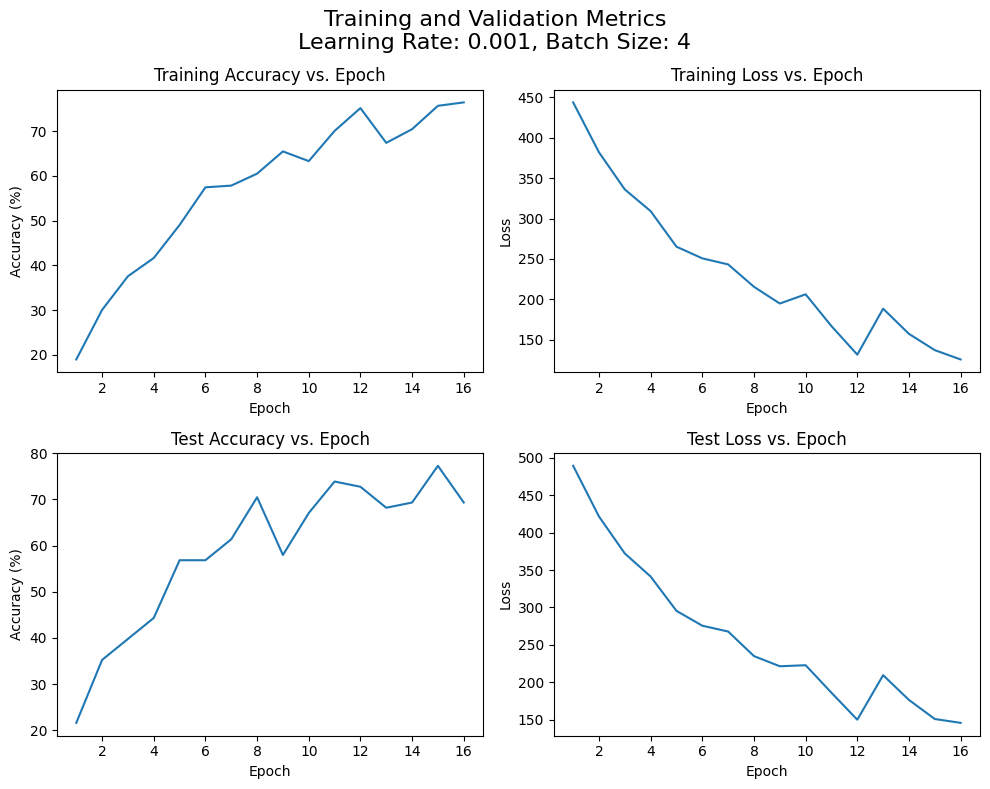

Finished Training
Final test accuracy = 69.32%
AlexNet took 88.4954903125763 seconds to train


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.0684, Accuracy: 25.22%
Epoch 2/16, Loss: 1.7437, Accuracy: 39.24%
Epoch 3/16, Loss: 1.3799, Accuracy: 51.59%
Epoch 4/16, Loss: 1.1577, Accuracy: 58.60%
Epoch 5/16, Loss: 0.9412, Accuracy: 66.50%
Epoch 6/16, Loss: 0.9132, Accuracy: 66.88%
Epoch 7/16, Loss: 0.9031, Accuracy: 67.26%
Epoch 8/16, Loss: 0.6688, Accuracy: 76.94%
Epoch 9/16, Loss: 0.5528, Accuracy: 79.75%
Epoch 10/16, Loss: 0.5114, Accuracy: 81.27%
Epoch 11/16, Loss: 0.4616, Accuracy: 84.20%
Epoch 12/16, Loss: 0.4250, Accuracy: 84.20%
Epoch 13/16, Loss: 0.3487, Accuracy: 86.62%
Epoch 14/16, Loss: 0.2718, Accuracy: 89.30%
Epoch 15/16, Loss: 0.2219, Accuracy: 91.08%
Epoch 16/16, Loss: 0.3499, Accuracy: 87.01%


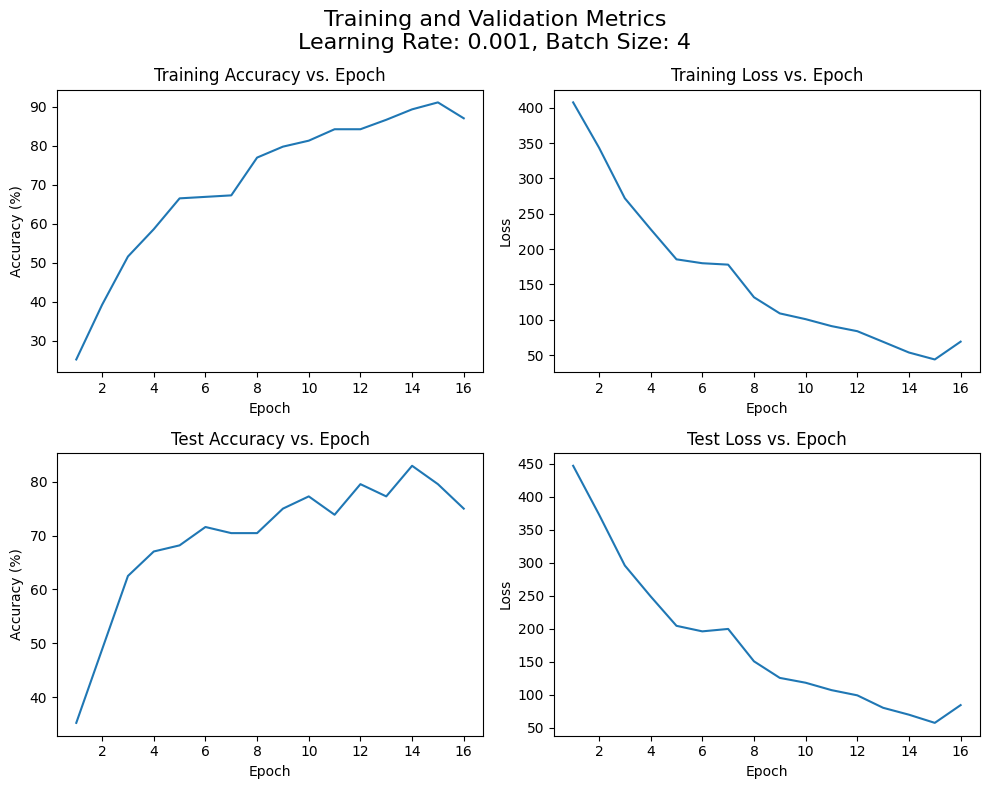

Finished Training
Final test accuracy = 75.00%
VGG11 took 227.50953674316406 seconds to train


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.0631, Accuracy: 39.11%
Epoch 2/16, Loss: 1.3150, Accuracy: 58.85%
Epoch 3/16, Loss: 0.9812, Accuracy: 67.90%
Epoch 4/16, Loss: 0.8294, Accuracy: 72.23%
Epoch 5/16, Loss: 0.6402, Accuracy: 78.34%
Epoch 6/16, Loss: 0.6073, Accuracy: 78.98%
Epoch 7/16, Loss: 0.4776, Accuracy: 84.20%
Epoch 8/16, Loss: 0.3959, Accuracy: 86.24%
Epoch 9/16, Loss: 0.3630, Accuracy: 87.52%
Epoch 10/16, Loss: 0.2801, Accuracy: 89.55%
Epoch 11/16, Loss: 0.2815, Accuracy: 91.34%
Epoch 12/16, Loss: 0.2883, Accuracy: 90.06%
Epoch 13/16, Loss: 0.2361, Accuracy: 92.61%
Epoch 14/16, Loss: 0.1798, Accuracy: 94.52%
Epoch 15/16, Loss: 0.2298, Accuracy: 92.48%
Epoch 16/16, Loss: 0.1626, Accuracy: 94.52%


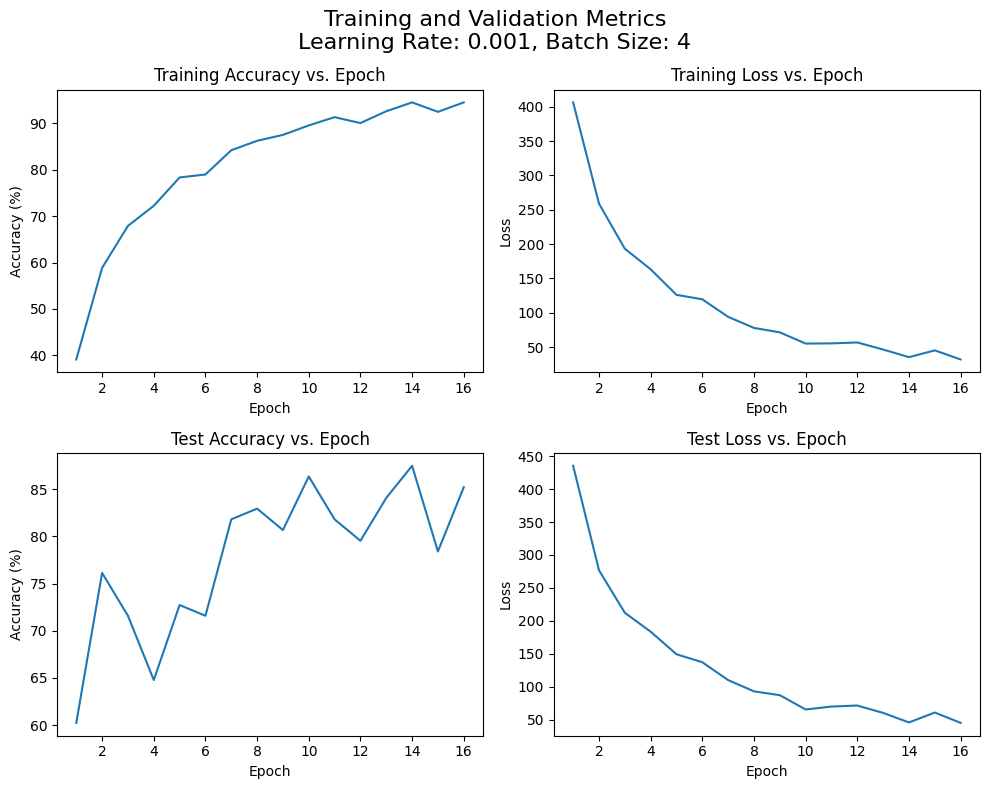

Finished Training
Final test accuracy = 85.23%
ResNet50 took 200.41455912590027 seconds to train


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.4215, Accuracy: 31.59%
Epoch 2/16, Loss: 1.5317, Accuracy: 48.41%
Epoch 3/16, Loss: 1.1796, Accuracy: 61.91%
Epoch 4/16, Loss: 0.9326, Accuracy: 68.03%
Epoch 5/16, Loss: 0.8364, Accuracy: 72.23%
Epoch 6/16, Loss: 0.7057, Accuracy: 76.94%
Epoch 7/16, Loss: 0.6154, Accuracy: 79.75%
Epoch 8/16, Loss: 0.5766, Accuracy: 81.40%
Epoch 9/16, Loss: 0.4840, Accuracy: 83.44%
Epoch 10/16, Loss: 0.4815, Accuracy: 83.57%
Epoch 11/16, Loss: 0.4296, Accuracy: 85.73%
Epoch 12/16, Loss: 0.3920, Accuracy: 88.03%
Epoch 13/16, Loss: 0.3272, Accuracy: 88.79%
Epoch 14/16, Loss: 0.3479, Accuracy: 88.92%
Epoch 15/16, Loss: 0.2788, Accuracy: 90.19%
Epoch 16/16, Loss: 0.3188, Accuracy: 89.55%


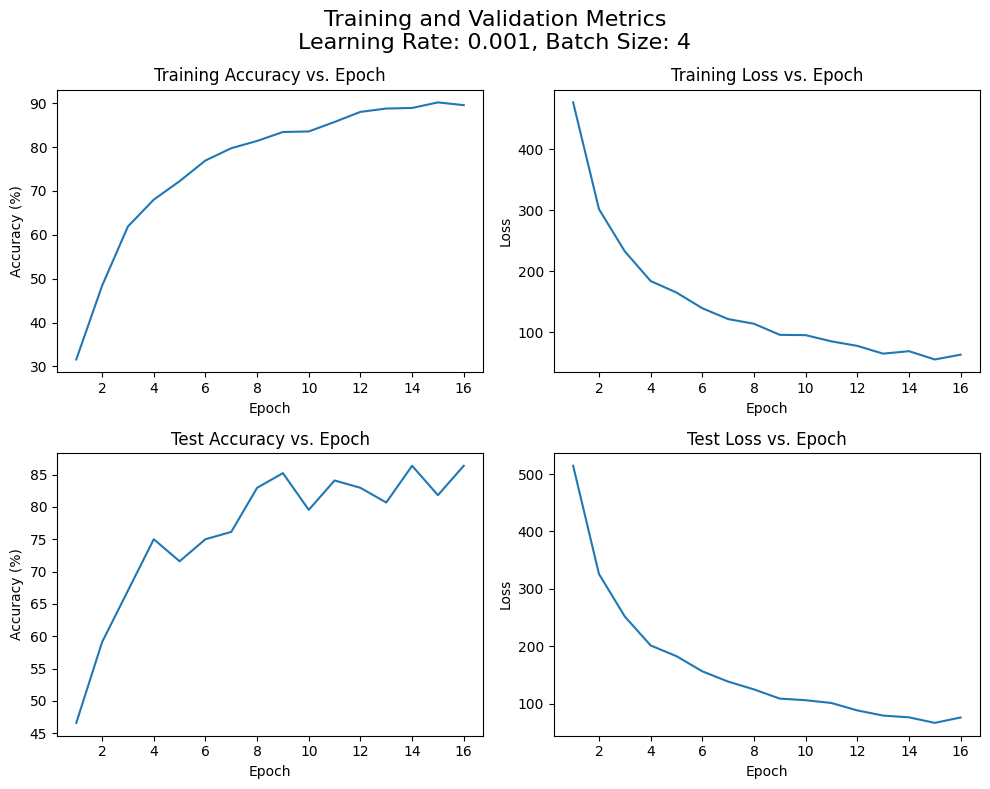

Finished Training
Final test accuracy = 86.36%
DenseNet121 took 274.3905906677246 seconds to train


In [ ]:

#googlenetTime = train_model(googlenetModel, googlenetModel, criterion, num_epochs)
#print(f"GoogLeNet took {googlenetTime} seconds to train")
alexnetTime = train_model(alexNetModel, alexNetoptimizer, criterion, num_epochs)
print(f"AlexNet took {alexnetTime} seconds to train")
vggTime = train_model(vgg11Model, vgg11optimizer, criterion, num_epochs)
print(f"VGG11 took {vggTime} seconds to train")
resnetTime = train_model(resNet50Model, resNet50optimizer, criterion, num_epochs)
print(f"ResNet50 took {resnetTime} seconds to train")
densenetTime = train_model(densenetModel, densenetOptimizer, criterion, num_epochs)
print(f"DenseNet121 took {densenetTime} seconds to train")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.1922, Accuracy: 21.78%
Epoch 2/16, Loss: 1.8953, Accuracy: 32.87%
Epoch 3/16, Loss: 1.5900, Accuracy: 43.57%
Epoch 4/16, Loss: 1.3927, Accuracy: 51.85%
Epoch 5/16, Loss: 1.2162, Accuracy: 56.56%
Epoch 6/16, Loss: 1.0125, Accuracy: 63.18%
Epoch 7/16, Loss: 0.9826, Accuracy: 66.88%
Epoch 8/16, Loss: 0.7611, Accuracy: 71.97%
Epoch 9/16, Loss: 0.7360, Accuracy: 72.23%
Epoch 10/16, Loss: 0.7797, Accuracy: 71.46%
Epoch 11/16, Loss: 0.7172, Accuracy: 76.43%
Epoch 12/16, Loss: 0.5971, Accuracy: 75.92%
Epoch 13/16, Loss: 0.6491, Accuracy: 76.05%
Epoch 14/16, Loss: 0.6386, Accuracy: 76.69%
Epoch 15/16, Loss: 0.4600, Accuracy: 82.17%
Epoch 16/16, Loss: 0.5479, Accuracy: 79.62%


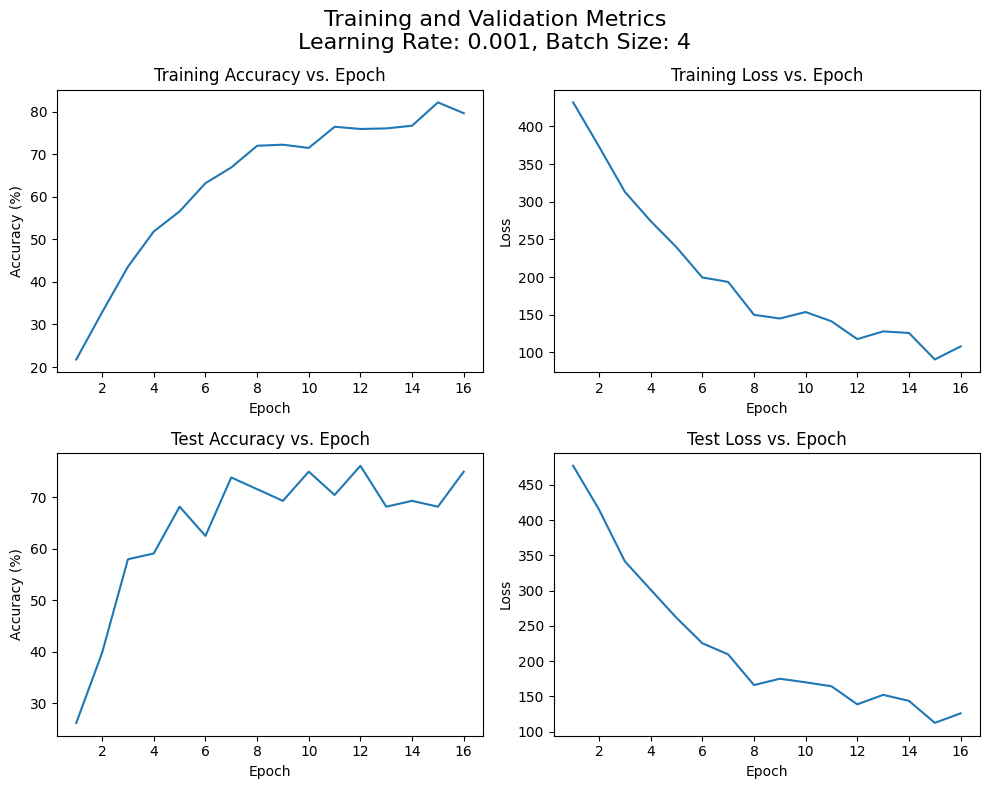

Finished Training
Final test accuracy = 75.00%
AlexNet took 84.2020366191864 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.0047, Accuracy: 29.04%
Epoch 2/16, Loss: 1.7088, Accuracy: 38.60%
Epoch 3/16, Loss: 1.3030, Accuracy: 54.14%
Epoch 4/16, Loss: 1.1588, Accuracy: 58.09%
Epoch 5/16, Loss: 0.9912, Accuracy: 64.84%
Epoch 6/16, Loss: 0.8499, Accuracy: 67.39%
Epoch 7/16, Loss: 0.8158, Accuracy: 68.92%
Epoch 8/16, Loss: 0.8054, Accuracy: 70.32%
Epoch 9/16, Loss: 0.7505, Accuracy: 77.20%
Epoch 10/16, Loss: 0.9240, Accuracy: 67.64%
Epoch 11/16, Loss: 0.6485, Accuracy: 75.67%
Epoch 12/16, Loss: 0.5517, Accuracy: 77.58%
Epoch 13/16, Loss: 0.5725, Accuracy: 78.73%
Epoch 14/16, Loss: 0.4759, Accuracy: 83.18%
Epoch 15/16, Loss: 0.4120, Accuracy: 82.80%
Epoch 16/16, Loss: 0.4110, Accuracy: 85.61%


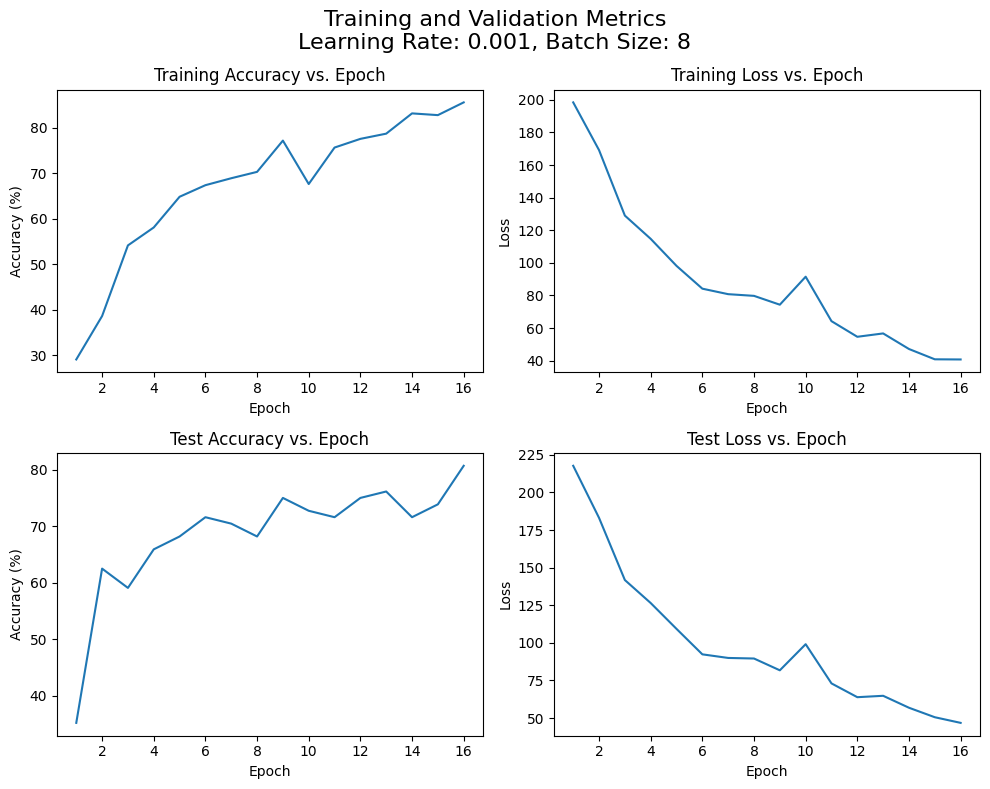

Finished Training
Final test accuracy = 80.68%
AlexNet took 64.09248733520508 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.9254, Accuracy: 33.63%
Epoch 2/16, Loss: 1.3919, Accuracy: 49.68%
Epoch 3/16, Loss: 1.4030, Accuracy: 50.96%
Epoch 4/16, Loss: 1.1898, Accuracy: 56.82%
Epoch 5/16, Loss: 0.9103, Accuracy: 67.77%
Epoch 6/16, Loss: 1.1968, Accuracy: 59.75%
Epoch 7/16, Loss: 0.8933, Accuracy: 68.03%
Epoch 8/16, Loss: 0.7833, Accuracy: 70.57%
Epoch 9/16, Loss: 0.6298, Accuracy: 77.32%
Epoch 10/16, Loss: 0.5852, Accuracy: 77.83%
Epoch 11/16, Loss: 0.5239, Accuracy: 78.47%
Epoch 12/16, Loss: 0.6941, Accuracy: 75.03%
Epoch 13/16, Loss: 0.5003, Accuracy: 80.51%
Epoch 14/16, Loss: 0.4236, Accuracy: 82.93%
Epoch 15/16, Loss: 0.4402, Accuracy: 84.08%
Epoch 16/16, Loss: 0.3412, Accuracy: 86.88%


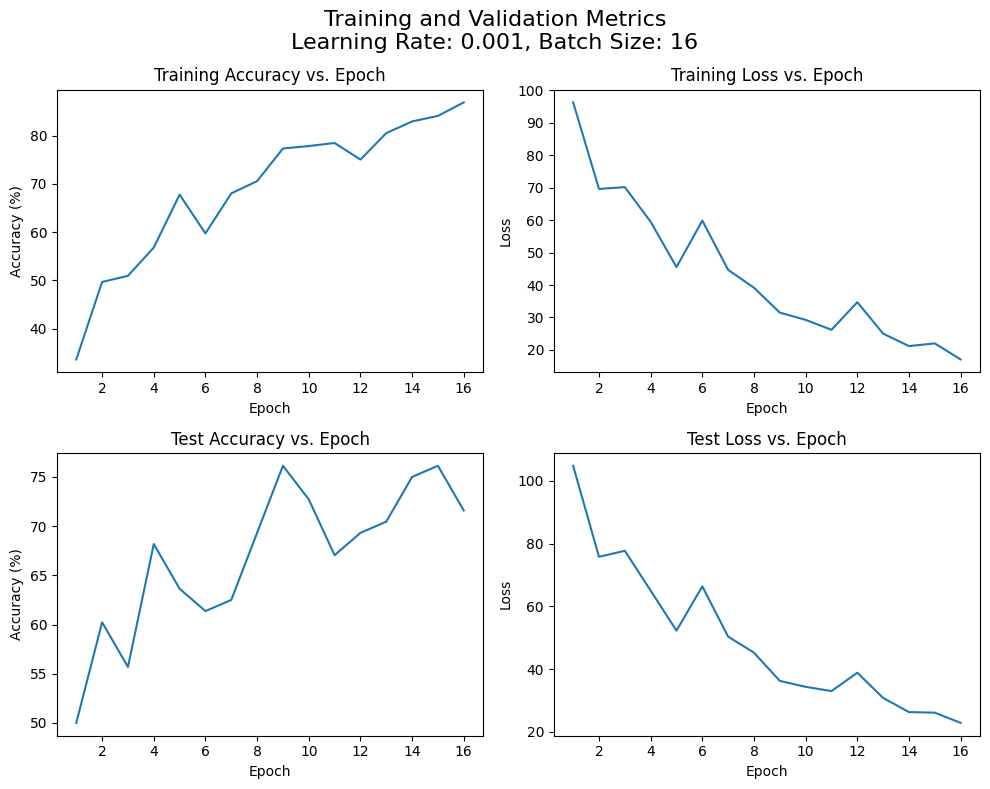

Finished Training
Final test accuracy = 71.59%
AlexNet took 48.500370025634766 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.0407, Accuracy: 25.86%
Epoch 2/16, Loss: 1.4974, Accuracy: 48.03%
Epoch 3/16, Loss: 1.1902, Accuracy: 57.83%
Epoch 4/16, Loss: 1.0515, Accuracy: 62.42%
Epoch 5/16, Loss: 0.9224, Accuracy: 66.24%
Epoch 6/16, Loss: 0.7437, Accuracy: 73.38%
Epoch 7/16, Loss: 0.6999, Accuracy: 74.01%
Epoch 8/16, Loss: 0.6237, Accuracy: 77.20%
Epoch 9/16, Loss: 0.6110, Accuracy: 77.32%
Epoch 10/16, Loss: 0.5511, Accuracy: 79.87%
Epoch 11/16, Loss: 0.5799, Accuracy: 78.85%
Epoch 12/16, Loss: 0.5466, Accuracy: 79.36%
Epoch 13/16, Loss: 0.4239, Accuracy: 83.95%
Epoch 14/16, Loss: 0.4696, Accuracy: 82.29%
Epoch 15/16, Loss: 0.4589, Accuracy: 82.55%
Epoch 16/16, Loss: 0.3559, Accuracy: 87.39%


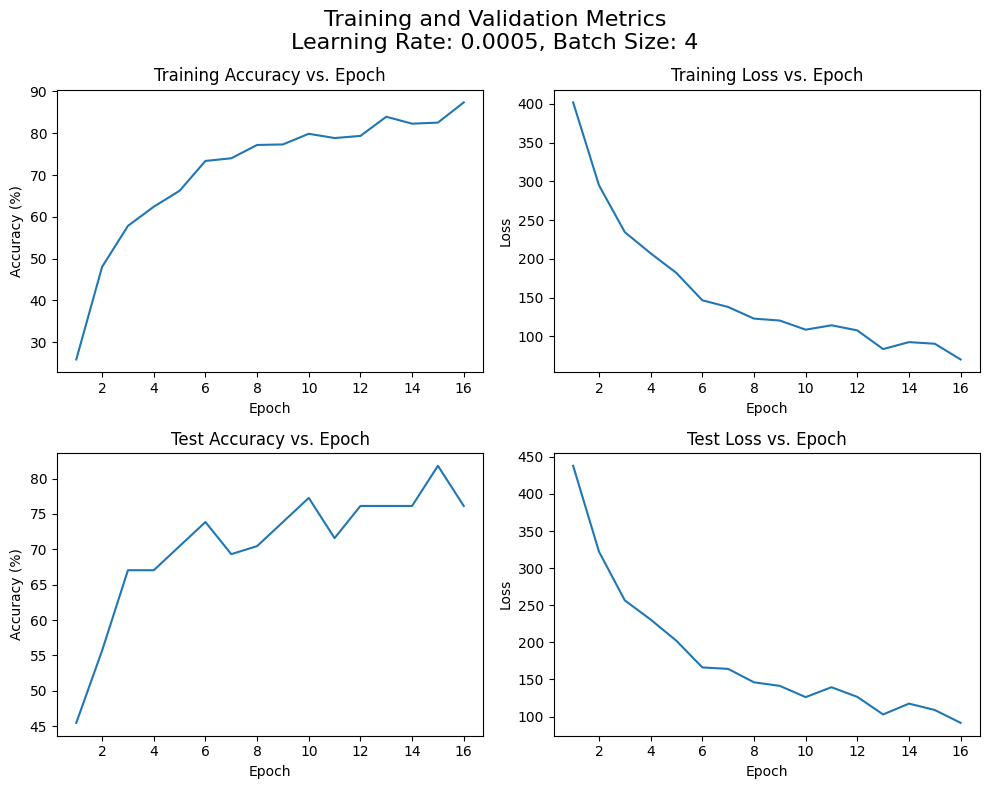

Finished Training
Final test accuracy = 76.14%
AlexNet took 85.21842193603516 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.8984, Accuracy: 32.23%
Epoch 2/16, Loss: 1.3633, Accuracy: 53.38%
Epoch 3/16, Loss: 1.2089, Accuracy: 55.67%
Epoch 4/16, Loss: 0.9767, Accuracy: 64.84%
Epoch 5/16, Loss: 0.8820, Accuracy: 67.77%
Epoch 6/16, Loss: 0.7730, Accuracy: 71.59%
Epoch 7/16, Loss: 0.7371, Accuracy: 72.36%
Epoch 8/16, Loss: 0.5930, Accuracy: 79.11%
Epoch 9/16, Loss: 0.5930, Accuracy: 77.32%
Epoch 10/16, Loss: 0.4753, Accuracy: 81.78%
Epoch 11/16, Loss: 0.4939, Accuracy: 80.51%
Epoch 12/16, Loss: 0.4372, Accuracy: 84.20%
Epoch 13/16, Loss: 0.3751, Accuracy: 85.86%
Epoch 14/16, Loss: 0.4632, Accuracy: 81.53%
Epoch 15/16, Loss: 0.3980, Accuracy: 84.71%
Epoch 16/16, Loss: 0.3012, Accuracy: 88.54%


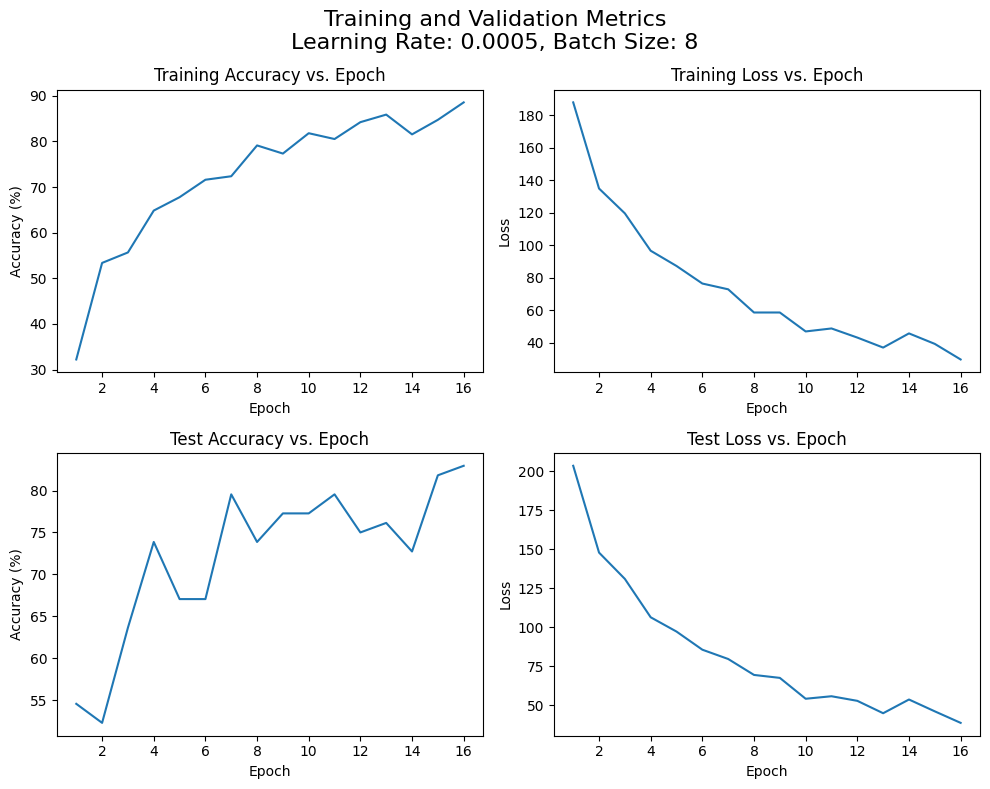

Finished Training
Final test accuracy = 82.95%
AlexNet took 63.29097127914429 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.8439, Accuracy: 33.38%
Epoch 2/16, Loss: 1.3418, Accuracy: 51.72%
Epoch 3/16, Loss: 1.1822, Accuracy: 56.56%
Epoch 4/16, Loss: 1.0937, Accuracy: 59.11%
Epoch 5/16, Loss: 0.8507, Accuracy: 70.45%
Epoch 6/16, Loss: 1.1398, Accuracy: 60.00%
Epoch 7/16, Loss: 0.8451, Accuracy: 69.81%
Epoch 8/16, Loss: 0.6685, Accuracy: 74.52%
Epoch 9/16, Loss: 0.6202, Accuracy: 77.32%
Epoch 10/16, Loss: 0.5521, Accuracy: 79.62%
Epoch 11/16, Loss: 0.5140, Accuracy: 80.25%
Epoch 12/16, Loss: 0.5159, Accuracy: 79.36%
Epoch 13/16, Loss: 0.3906, Accuracy: 85.35%
Epoch 14/16, Loss: 0.3852, Accuracy: 84.71%
Epoch 15/16, Loss: 0.3581, Accuracy: 86.75%
Epoch 16/16, Loss: 0.4647, Accuracy: 83.31%


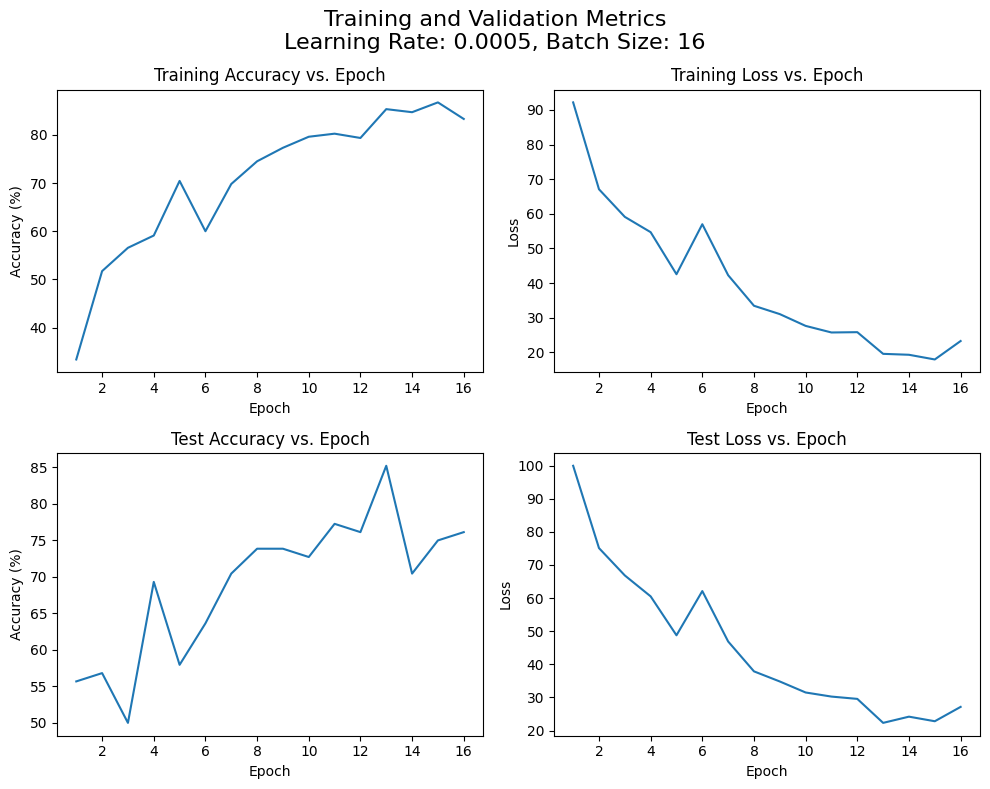

Finished Training
Final test accuracy = 76.14%
AlexNet took 49.65028643608093 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.8557, Accuracy: 35.16%
Epoch 2/16, Loss: 1.3264, Accuracy: 52.36%
Epoch 3/16, Loss: 1.0699, Accuracy: 61.53%
Epoch 4/16, Loss: 0.9592, Accuracy: 65.73%
Epoch 5/16, Loss: 0.8803, Accuracy: 68.92%
Epoch 6/16, Loss: 0.7340, Accuracy: 74.39%
Epoch 7/16, Loss: 0.6931, Accuracy: 73.76%
Epoch 8/16, Loss: 0.6246, Accuracy: 77.58%
Epoch 9/16, Loss: 0.6396, Accuracy: 77.32%
Epoch 10/16, Loss: 0.5500, Accuracy: 79.11%
Epoch 11/16, Loss: 0.4879, Accuracy: 80.51%
Epoch 12/16, Loss: 0.4948, Accuracy: 81.78%
Epoch 13/16, Loss: 0.4354, Accuracy: 83.31%
Epoch 14/16, Loss: 0.4182, Accuracy: 83.69%
Epoch 15/16, Loss: 0.3659, Accuracy: 85.61%
Epoch 16/16, Loss: 0.3424, Accuracy: 87.26%


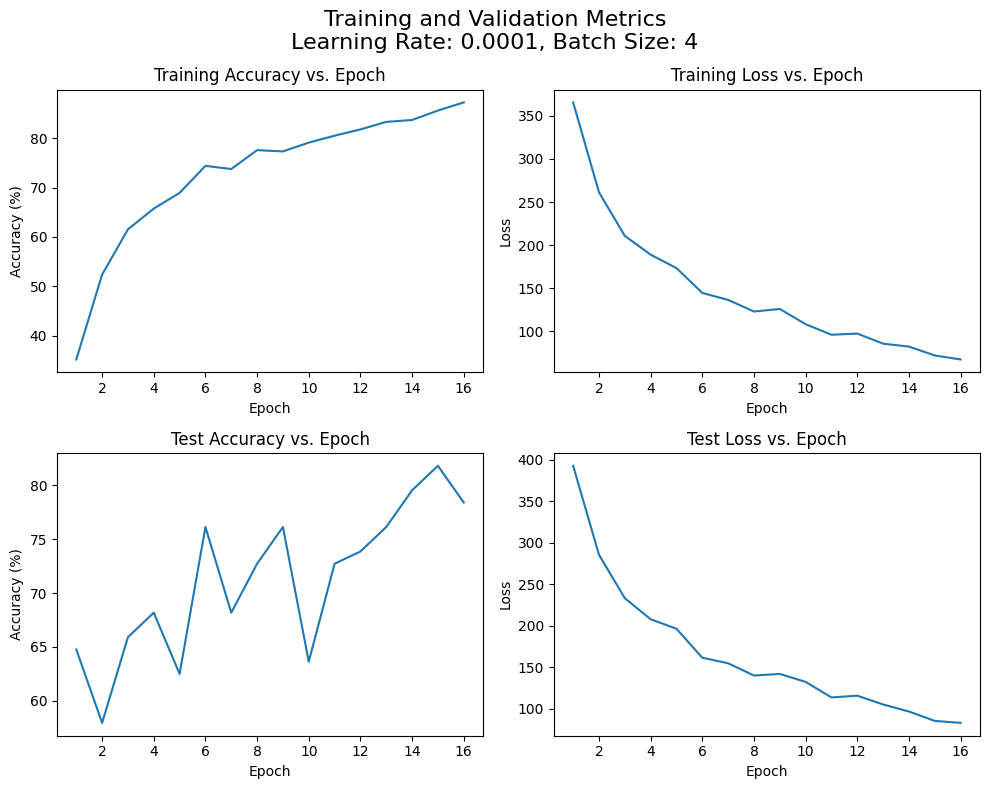

Finished Training
Final test accuracy = 78.41%
AlexNet took 85.76537132263184 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.1066, Accuracy: 25.86%
Epoch 2/16, Loss: 1.5665, Accuracy: 46.62%
Epoch 3/16, Loss: 1.2636, Accuracy: 55.67%
Epoch 4/16, Loss: 1.0425, Accuracy: 63.82%
Epoch 5/16, Loss: 0.9326, Accuracy: 67.26%
Epoch 6/16, Loss: 0.8415, Accuracy: 70.19%
Epoch 7/16, Loss: 0.7839, Accuracy: 72.74%
Epoch 8/16, Loss: 0.8002, Accuracy: 71.08%
Epoch 9/16, Loss: 0.6537, Accuracy: 76.82%
Epoch 10/16, Loss: 0.6235, Accuracy: 77.32%
Epoch 11/16, Loss: 0.5828, Accuracy: 78.73%
Epoch 12/16, Loss: 0.5056, Accuracy: 82.04%
Epoch 13/16, Loss: 0.5177, Accuracy: 82.17%
Epoch 14/16, Loss: 0.4151, Accuracy: 84.97%
Epoch 15/16, Loss: 0.4482, Accuracy: 83.18%
Epoch 16/16, Loss: 0.4678, Accuracy: 82.42%


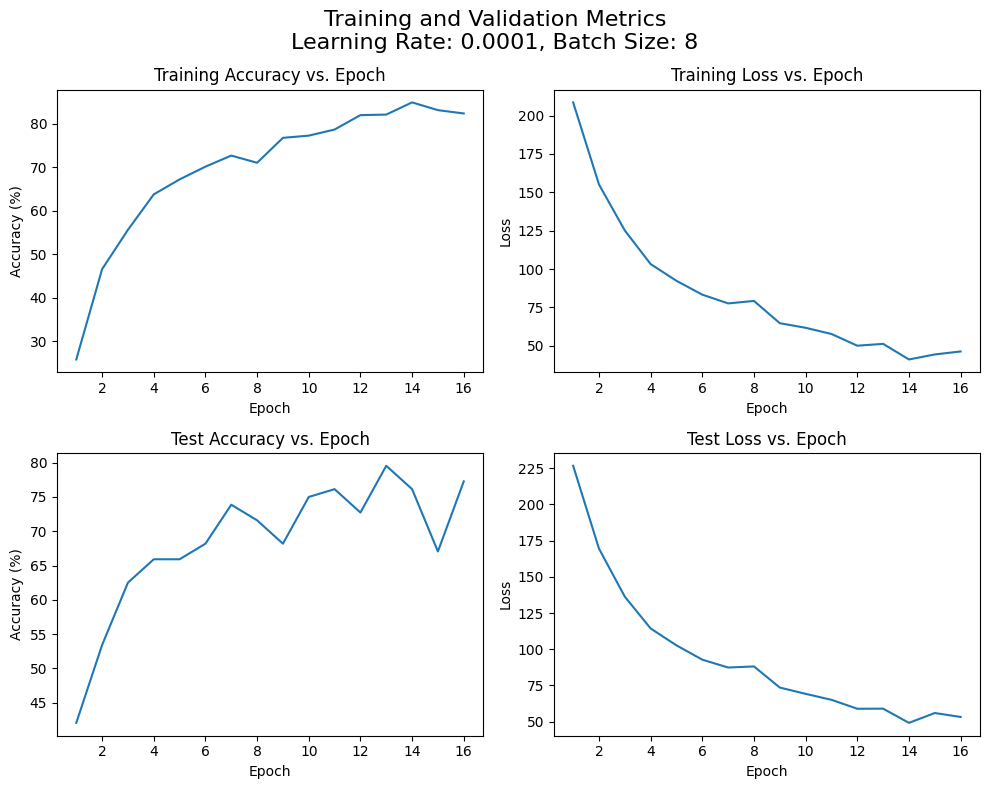

Finished Training
Final test accuracy = 77.27%
AlexNet took 61.76985740661621 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.1311, Accuracy: 24.84%
Epoch 2/16, Loss: 1.6677, Accuracy: 41.78%
Epoch 3/16, Loss: 1.4128, Accuracy: 48.66%
Epoch 4/16, Loss: 1.1827, Accuracy: 59.49%
Epoch 5/16, Loss: 1.0906, Accuracy: 60.64%
Epoch 6/16, Loss: 0.9660, Accuracy: 64.71%
Epoch 7/16, Loss: 0.9211, Accuracy: 65.10%
Epoch 8/16, Loss: 0.7746, Accuracy: 71.59%
Epoch 9/16, Loss: 0.7852, Accuracy: 69.81%
Epoch 10/16, Loss: 0.7139, Accuracy: 75.41%
Epoch 11/16, Loss: 0.7126, Accuracy: 73.76%
Epoch 12/16, Loss: 0.6461, Accuracy: 74.78%
Epoch 13/16, Loss: 0.6204, Accuracy: 76.31%
Epoch 14/16, Loss: 0.6476, Accuracy: 78.34%
Epoch 15/16, Loss: 0.8138, Accuracy: 71.08%
Epoch 16/16, Loss: 0.5751, Accuracy: 77.96%


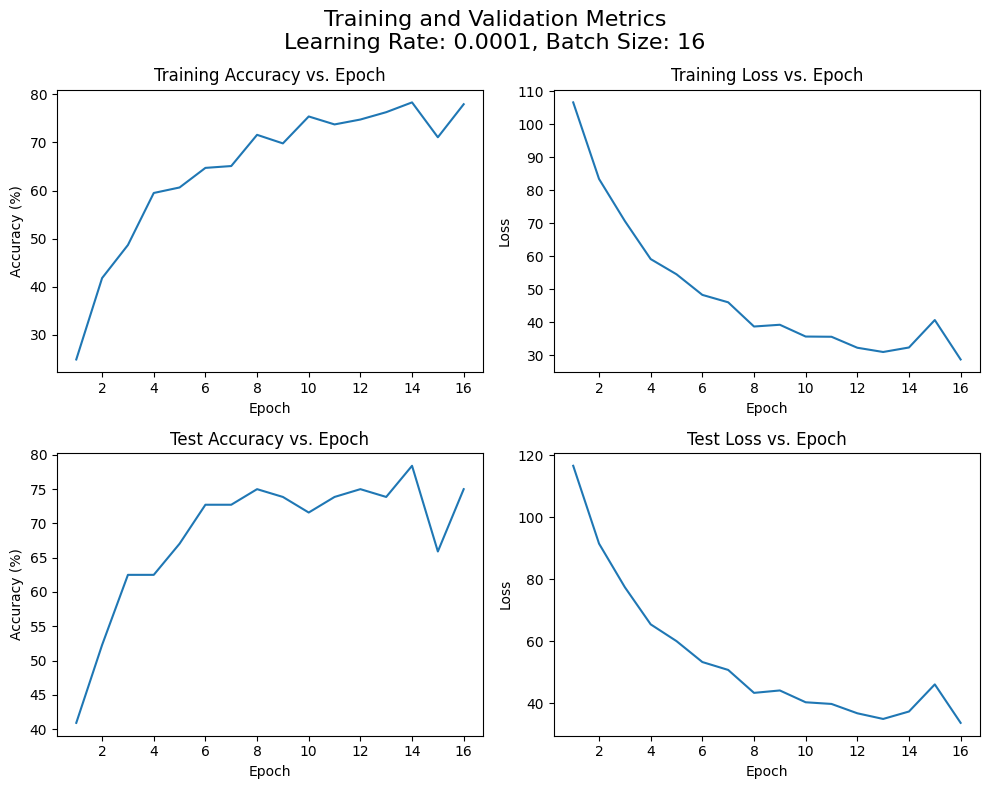

Finished Training
Final test accuracy = 75.00%
AlexNet took 50.15193557739258 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.8382, Accuracy: 37.58%
Epoch 2/16, Loss: 1.2896, Accuracy: 55.67%
Epoch 3/16, Loss: 1.0759, Accuracy: 60.89%
Epoch 4/16, Loss: 0.9294, Accuracy: 65.22%
Epoch 5/16, Loss: 0.8188, Accuracy: 71.97%
Epoch 6/16, Loss: 0.7696, Accuracy: 71.08%
Epoch 7/16, Loss: 0.7106, Accuracy: 73.89%
Epoch 8/16, Loss: 0.6321, Accuracy: 76.31%
Epoch 9/16, Loss: 0.5824, Accuracy: 78.22%
Epoch 10/16, Loss: 0.5730, Accuracy: 81.02%
Epoch 11/16, Loss: 0.5096, Accuracy: 81.53%
Epoch 12/16, Loss: 0.5186, Accuracy: 81.15%
Epoch 13/16, Loss: 0.4787, Accuracy: 83.57%
Epoch 14/16, Loss: 0.4587, Accuracy: 83.57%
Epoch 15/16, Loss: 0.4262, Accuracy: 84.08%
Epoch 16/16, Loss: 0.4297, Accuracy: 84.46%


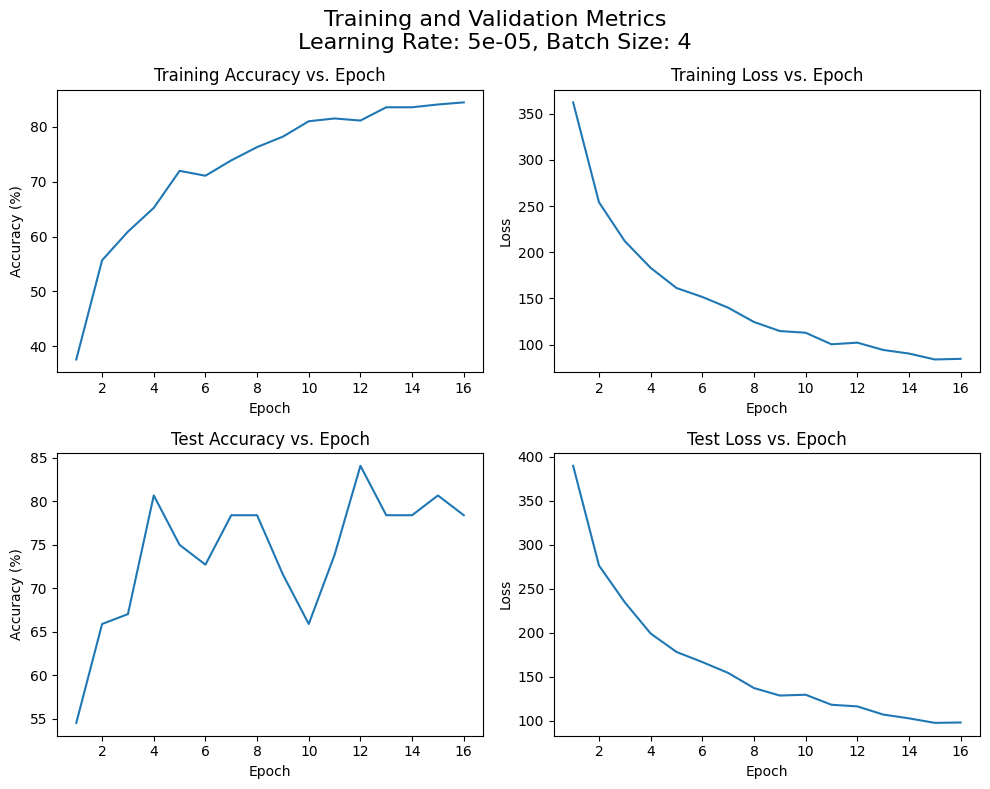

Finished Training
Final test accuracy = 78.41%
AlexNet took 85.10249638557434 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.0595, Accuracy: 26.37%
Epoch 2/16, Loss: 1.5107, Accuracy: 47.13%
Epoch 3/16, Loss: 1.3450, Accuracy: 51.85%
Epoch 4/16, Loss: 1.1413, Accuracy: 59.24%
Epoch 5/16, Loss: 0.9830, Accuracy: 65.73%
Epoch 6/16, Loss: 0.8937, Accuracy: 67.77%
Epoch 7/16, Loss: 0.8397, Accuracy: 70.06%
Epoch 8/16, Loss: 0.8330, Accuracy: 70.19%
Epoch 9/16, Loss: 0.7217, Accuracy: 74.27%
Epoch 10/16, Loss: 0.6973, Accuracy: 74.52%
Epoch 11/16, Loss: 0.6499, Accuracy: 77.71%
Epoch 12/16, Loss: 0.6288, Accuracy: 77.58%
Epoch 13/16, Loss: 0.6069, Accuracy: 77.07%
Epoch 14/16, Loss: 0.5646, Accuracy: 79.87%
Epoch 15/16, Loss: 0.5551, Accuracy: 80.51%
Epoch 16/16, Loss: 0.4788, Accuracy: 82.42%


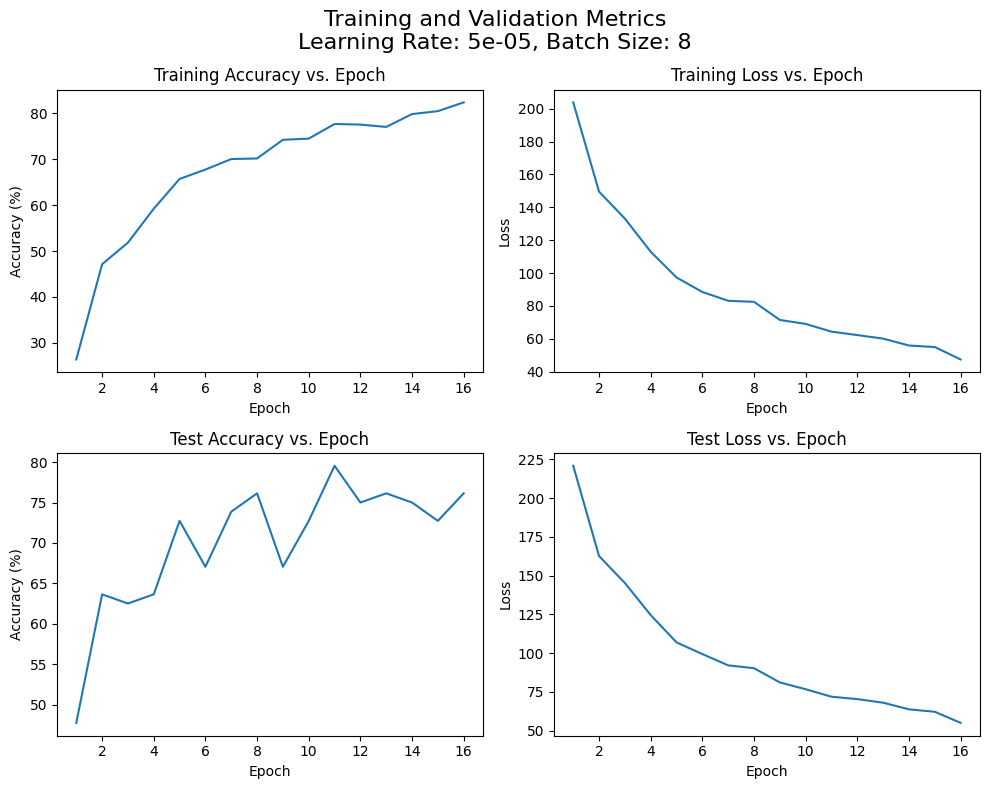

Finished Training
Final test accuracy = 76.14%
AlexNet took 64.14906024932861 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.3998, Accuracy: 16.69%
Epoch 2/16, Loss: 1.8763, Accuracy: 32.48%
Epoch 3/16, Loss: 1.6145, Accuracy: 42.68%
Epoch 4/16, Loss: 1.5307, Accuracy: 49.30%
Epoch 5/16, Loss: 1.3224, Accuracy: 53.38%
Epoch 6/16, Loss: 1.2418, Accuracy: 58.47%
Epoch 7/16, Loss: 1.1082, Accuracy: 61.66%
Epoch 8/16, Loss: 1.0376, Accuracy: 64.71%
Epoch 9/16, Loss: 1.0129, Accuracy: 65.99%
Epoch 10/16, Loss: 1.0716, Accuracy: 62.93%
Epoch 11/16, Loss: 0.9009, Accuracy: 68.15%
Epoch 12/16, Loss: 0.8887, Accuracy: 68.03%
Epoch 13/16, Loss: 0.7785, Accuracy: 73.76%
Epoch 14/16, Loss: 0.7977, Accuracy: 72.10%
Epoch 15/16, Loss: 0.7119, Accuracy: 72.74%
Epoch 16/16, Loss: 0.7007, Accuracy: 75.92%


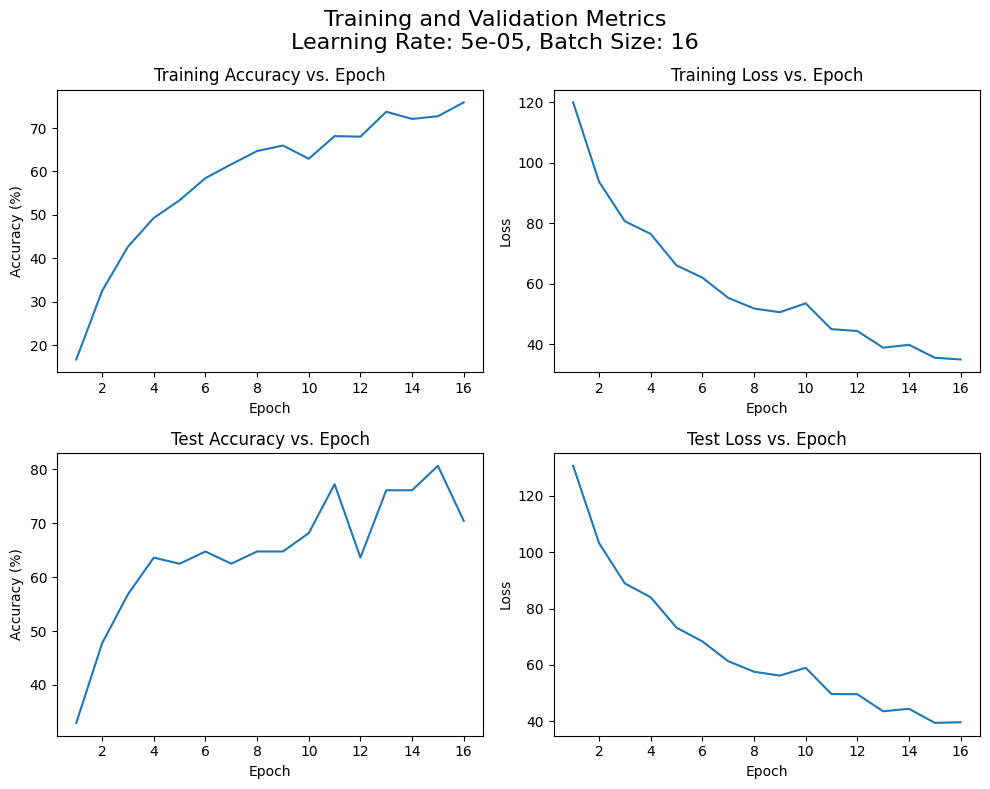

Finished Training
Final test accuracy = 70.45%
AlexNet took 49.68975901603699 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.1888, Accuracy: 34.27%
Epoch 2/16, Loss: 1.2930, Accuracy: 56.69%
Epoch 3/16, Loss: 1.0399, Accuracy: 64.33%
Epoch 4/16, Loss: 0.8358, Accuracy: 74.52%
Epoch 5/16, Loss: 0.6649, Accuracy: 78.47%
Epoch 6/16, Loss: 0.5627, Accuracy: 80.89%
Epoch 7/16, Loss: 0.5014, Accuracy: 83.31%
Epoch 8/16, Loss: 0.4570, Accuracy: 84.59%
Epoch 9/16, Loss: 0.4210, Accuracy: 85.22%
Epoch 10/16, Loss: 0.3361, Accuracy: 89.43%
Epoch 11/16, Loss: 0.3346, Accuracy: 89.17%
Epoch 12/16, Loss: 0.3616, Accuracy: 88.92%
Epoch 13/16, Loss: 0.2476, Accuracy: 91.59%
Epoch 14/16, Loss: 0.2198, Accuracy: 92.48%
Epoch 15/16, Loss: 0.1738, Accuracy: 94.39%
Epoch 16/16, Loss: 0.2215, Accuracy: 92.74%


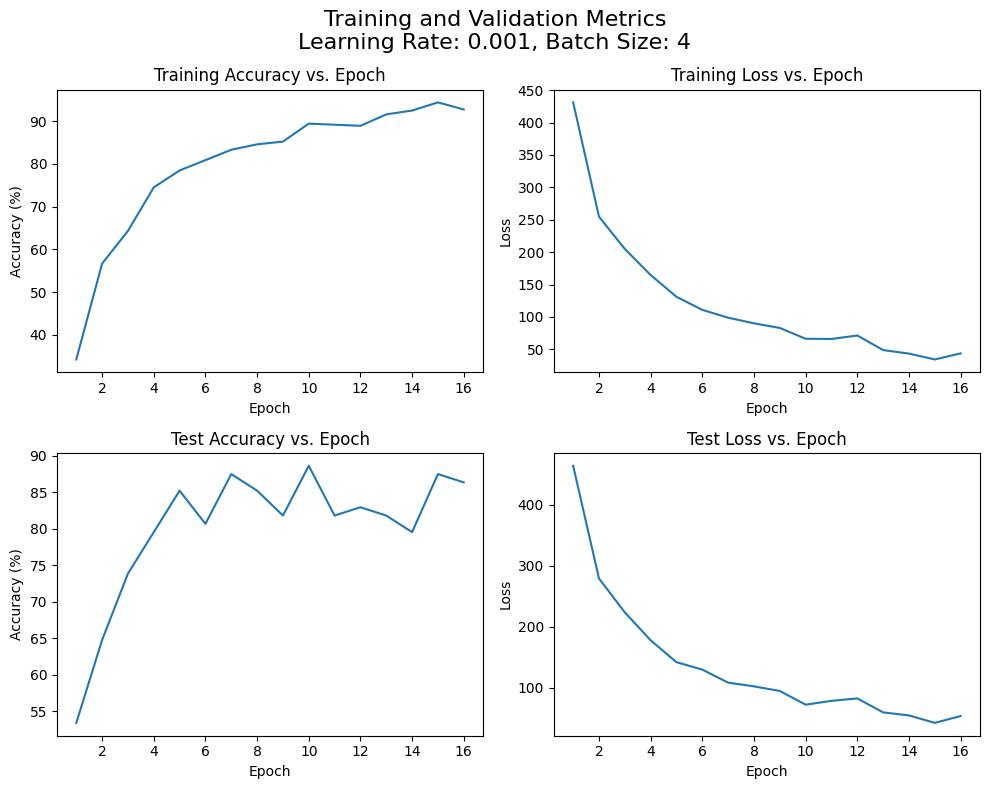

Finished Training
Final test accuracy = 86.36%
ResNet50 took 199.54932689666748 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.8104, Accuracy: 43.06%
Epoch 2/16, Loss: 1.3255, Accuracy: 61.15%
Epoch 3/16, Loss: 0.8970, Accuracy: 68.15%
Epoch 4/16, Loss: 0.6937, Accuracy: 75.92%
Epoch 5/16, Loss: 0.5603, Accuracy: 82.55%
Epoch 6/16, Loss: 0.5282, Accuracy: 85.10%
Epoch 7/16, Loss: 0.3396, Accuracy: 87.90%
Epoch 8/16, Loss: 0.2977, Accuracy: 90.57%
Epoch 9/16, Loss: 0.2806, Accuracy: 90.32%
Epoch 10/16, Loss: 0.2483, Accuracy: 92.87%
Epoch 11/16, Loss: 0.2293, Accuracy: 92.61%
Epoch 12/16, Loss: 0.2102, Accuracy: 93.50%
Epoch 13/16, Loss: 0.2167, Accuracy: 91.59%
Epoch 14/16, Loss: 0.2291, Accuracy: 93.25%
Epoch 15/16, Loss: 0.2162, Accuracy: 92.36%
Epoch 16/16, Loss: 0.1760, Accuracy: 94.39%


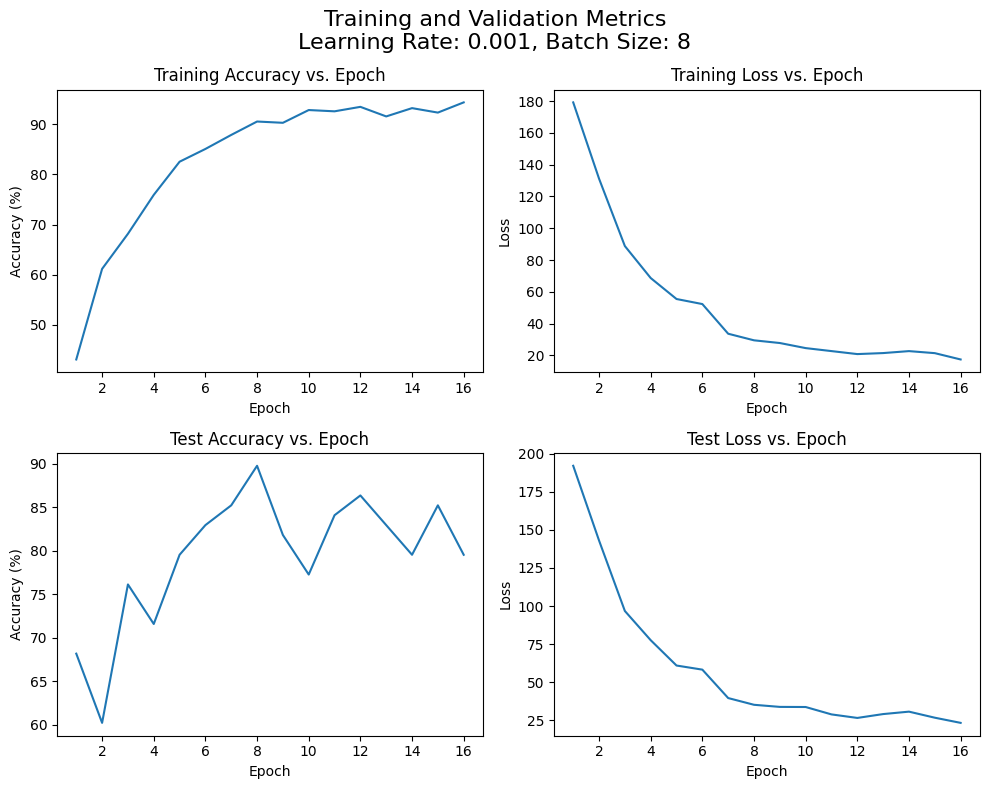

Finished Training
Final test accuracy = 79.55%
ResNet50 took 181.02099657058716 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.5831, Accuracy: 47.26%
Epoch 2/16, Loss: 0.8387, Accuracy: 74.27%
Epoch 3/16, Loss: 0.5306, Accuracy: 82.29%
Epoch 4/16, Loss: 0.3557, Accuracy: 89.43%
Epoch 5/16, Loss: 0.3530, Accuracy: 88.79%
Epoch 6/16, Loss: 0.3457, Accuracy: 89.94%
Epoch 7/16, Loss: 0.2780, Accuracy: 91.97%
Epoch 8/16, Loss: 0.2860, Accuracy: 90.83%
Epoch 9/16, Loss: 0.2624, Accuracy: 94.01%
Epoch 10/16, Loss: 0.2094, Accuracy: 94.01%
Epoch 11/16, Loss: 0.2095, Accuracy: 94.90%
Epoch 12/16, Loss: 0.2066, Accuracy: 95.67%
Epoch 13/16, Loss: 0.1619, Accuracy: 95.80%
Epoch 14/16, Loss: 0.1860, Accuracy: 95.54%
Epoch 15/16, Loss: 0.1610, Accuracy: 95.41%
Epoch 16/16, Loss: 0.1626, Accuracy: 95.80%


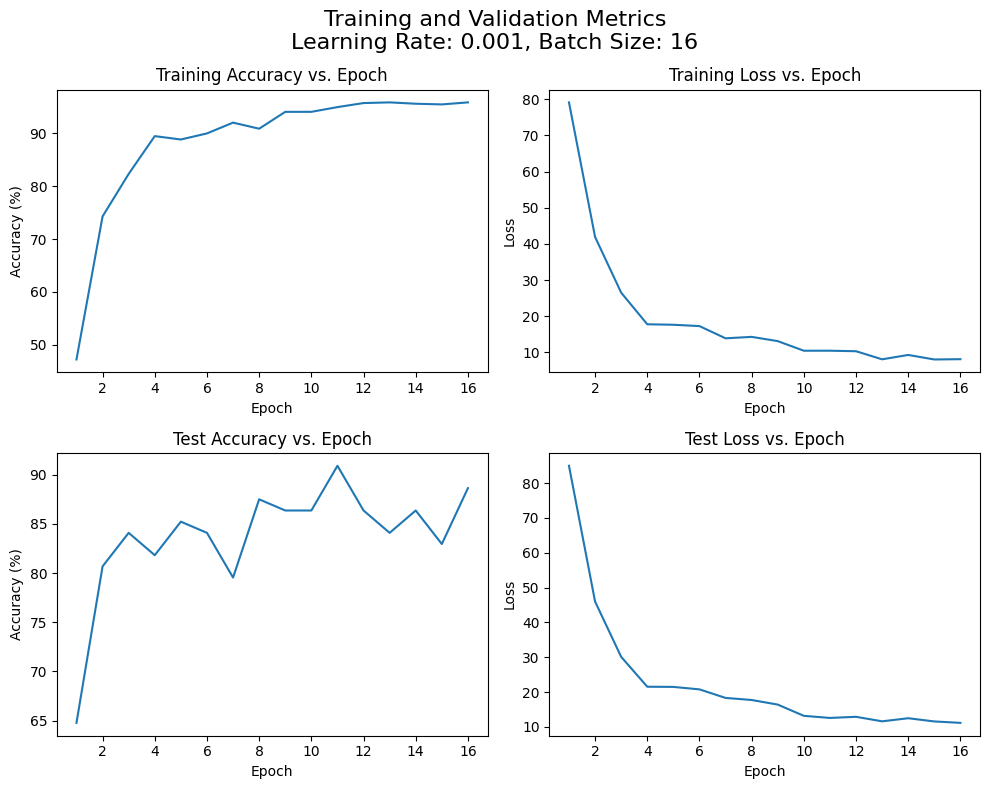

Finished Training
Final test accuracy = 88.64%
ResNet50 took 166.7857620716095 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.9368, Accuracy: 37.07%
Epoch 2/16, Loss: 1.4363, Accuracy: 52.87%
Epoch 3/16, Loss: 1.0747, Accuracy: 64.33%
Epoch 4/16, Loss: 0.7900, Accuracy: 74.90%
Epoch 5/16, Loss: 0.7036, Accuracy: 77.32%
Epoch 6/16, Loss: 0.5484, Accuracy: 82.29%
Epoch 7/16, Loss: 0.3929, Accuracy: 85.61%
Epoch 8/16, Loss: 0.4859, Accuracy: 82.80%
Epoch 9/16, Loss: 0.3365, Accuracy: 89.68%
Epoch 10/16, Loss: 0.3092, Accuracy: 90.57%
Epoch 11/16, Loss: 0.3426, Accuracy: 89.04%
Epoch 12/16, Loss: 0.2618, Accuracy: 90.57%
Epoch 13/16, Loss: 0.2904, Accuracy: 90.96%
Epoch 14/16, Loss: 0.2055, Accuracy: 93.12%
Epoch 15/16, Loss: 0.2223, Accuracy: 92.99%
Epoch 16/16, Loss: 0.2157, Accuracy: 93.89%


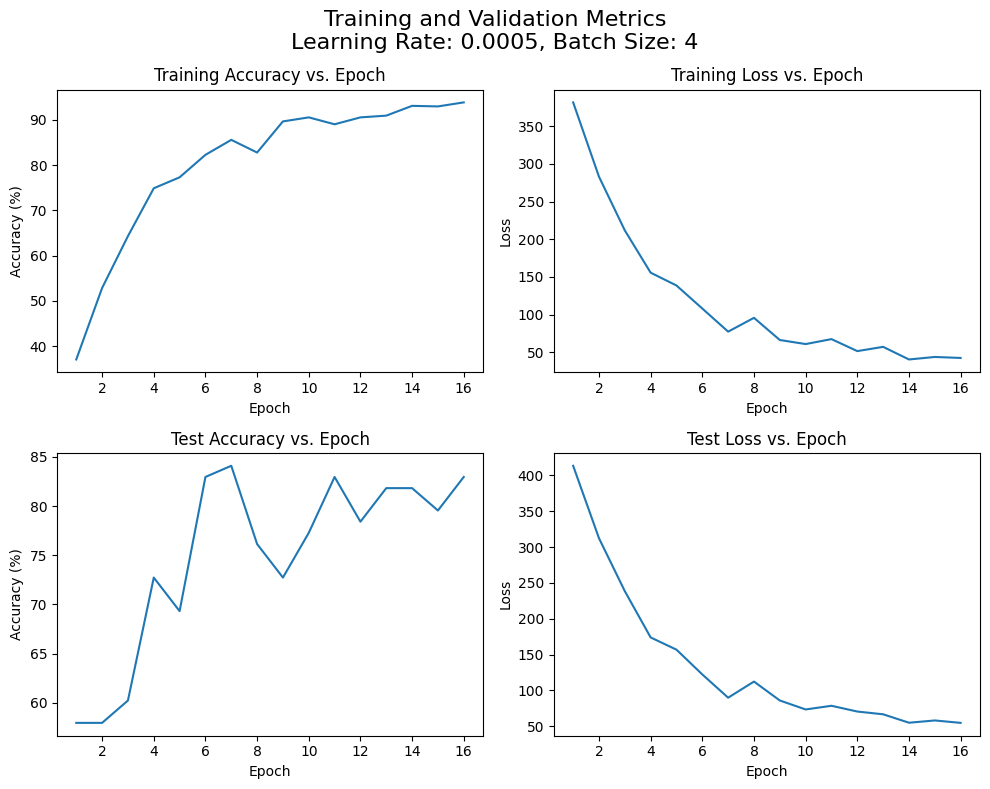

Finished Training
Final test accuracy = 82.95%
ResNet50 took 202.43859434127808 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.6836, Accuracy: 43.69%
Epoch 2/16, Loss: 0.9636, Accuracy: 69.17%
Epoch 3/16, Loss: 0.6816, Accuracy: 78.34%
Epoch 4/16, Loss: 0.4993, Accuracy: 83.06%
Epoch 5/16, Loss: 0.4160, Accuracy: 86.24%
Epoch 6/16, Loss: 0.2647, Accuracy: 91.97%
Epoch 7/16, Loss: 0.2345, Accuracy: 92.36%
Epoch 8/16, Loss: 0.2387, Accuracy: 92.36%
Epoch 9/16, Loss: 0.2767, Accuracy: 91.08%
Epoch 10/16, Loss: 0.2151, Accuracy: 93.38%
Epoch 11/16, Loss: 0.2304, Accuracy: 93.50%
Epoch 12/16, Loss: 0.1864, Accuracy: 93.38%
Epoch 13/16, Loss: 0.1666, Accuracy: 94.39%
Epoch 14/16, Loss: 0.1316, Accuracy: 95.29%
Epoch 15/16, Loss: 0.1477, Accuracy: 95.41%
Epoch 16/16, Loss: 0.1588, Accuracy: 95.29%


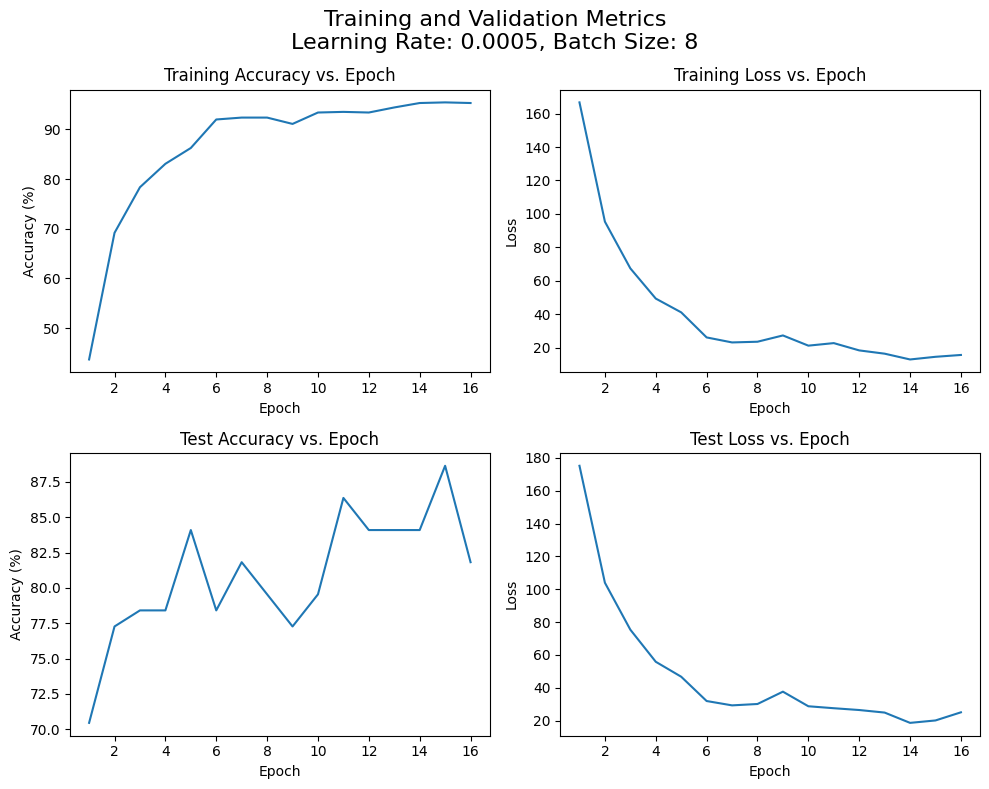

Finished Training
Final test accuracy = 81.82%
ResNet50 took 178.54410982131958 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.6734, Accuracy: 43.31%
Epoch 2/16, Loss: 0.8422, Accuracy: 74.14%
Epoch 3/16, Loss: 0.4968, Accuracy: 85.86%
Epoch 4/16, Loss: 0.3405, Accuracy: 90.45%
Epoch 5/16, Loss: 0.2950, Accuracy: 92.48%
Epoch 6/16, Loss: 0.2203, Accuracy: 94.52%
Epoch 7/16, Loss: 0.1889, Accuracy: 95.16%
Epoch 8/16, Loss: 0.1959, Accuracy: 95.41%
Epoch 9/16, Loss: 0.1889, Accuracy: 95.16%
Epoch 10/16, Loss: 0.1732, Accuracy: 94.78%
Epoch 11/16, Loss: 0.1672, Accuracy: 96.43%
Epoch 12/16, Loss: 0.1731, Accuracy: 95.80%
Epoch 13/16, Loss: 0.1476, Accuracy: 96.05%
Epoch 14/16, Loss: 0.1620, Accuracy: 96.05%
Epoch 15/16, Loss: 0.1554, Accuracy: 96.56%
Epoch 16/16, Loss: 0.1135, Accuracy: 96.31%


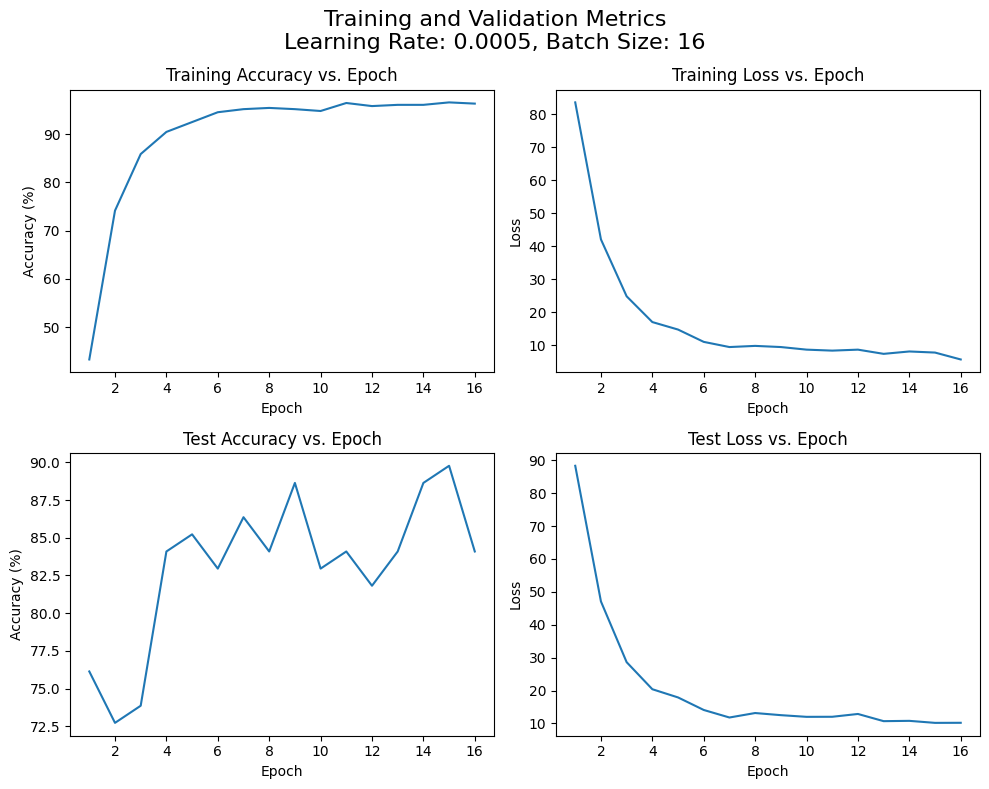

Finished Training
Final test accuracy = 84.09%
ResNet50 took 164.70420742034912 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.8925, Accuracy: 33.38%
Epoch 2/16, Loss: 1.2863, Accuracy: 56.43%
Epoch 3/16, Loss: 1.0317, Accuracy: 66.50%
Epoch 4/16, Loss: 0.8105, Accuracy: 71.85%
Epoch 5/16, Loss: 0.7052, Accuracy: 77.45%
Epoch 6/16, Loss: 0.5875, Accuracy: 82.55%
Epoch 7/16, Loss: 0.4697, Accuracy: 83.31%
Epoch 8/16, Loss: 0.4692, Accuracy: 85.22%
Epoch 9/16, Loss: 0.4036, Accuracy: 88.15%
Epoch 10/16, Loss: 0.4072, Accuracy: 86.88%
Epoch 11/16, Loss: 0.3956, Accuracy: 88.15%
Epoch 12/16, Loss: 0.3206, Accuracy: 90.83%
Epoch 13/16, Loss: 0.2767, Accuracy: 91.46%
Epoch 14/16, Loss: 0.2706, Accuracy: 92.10%
Epoch 15/16, Loss: 0.2597, Accuracy: 91.85%
Epoch 16/16, Loss: 0.2769, Accuracy: 91.85%


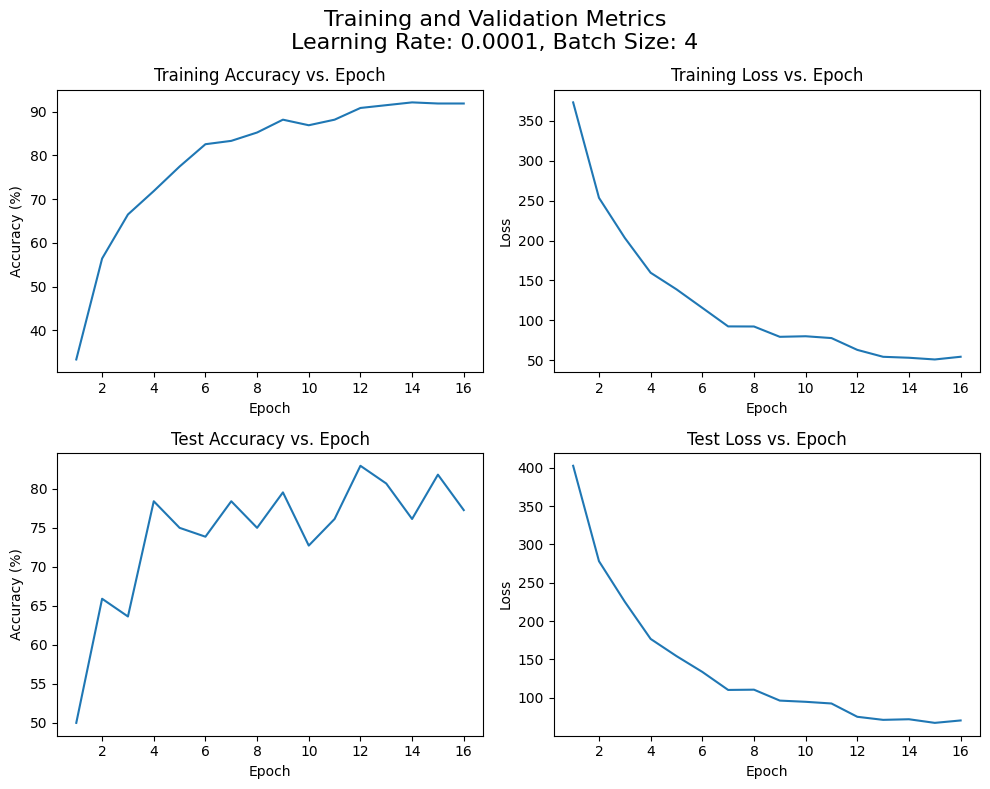

Finished Training
Final test accuracy = 77.27%
ResNet50 took 199.90525770187378 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.9044, Accuracy: 32.74%
Epoch 2/16, Loss: 1.2224, Accuracy: 59.75%
Epoch 3/16, Loss: 0.9114, Accuracy: 71.46%
Epoch 4/16, Loss: 0.7427, Accuracy: 76.56%
Epoch 5/16, Loss: 0.5878, Accuracy: 81.78%
Epoch 6/16, Loss: 0.4564, Accuracy: 86.75%
Epoch 7/16, Loss: 0.3516, Accuracy: 89.55%
Epoch 8/16, Loss: 0.3414, Accuracy: 90.32%
Epoch 9/16, Loss: 0.2936, Accuracy: 92.99%
Epoch 10/16, Loss: 0.2371, Accuracy: 93.12%
Epoch 11/16, Loss: 0.2148, Accuracy: 93.76%
Epoch 12/16, Loss: 0.2412, Accuracy: 92.99%
Epoch 13/16, Loss: 0.2344, Accuracy: 93.76%
Epoch 14/16, Loss: 0.1895, Accuracy: 94.65%
Epoch 15/16, Loss: 0.1650, Accuracy: 95.41%
Epoch 16/16, Loss: 0.1638, Accuracy: 95.41%


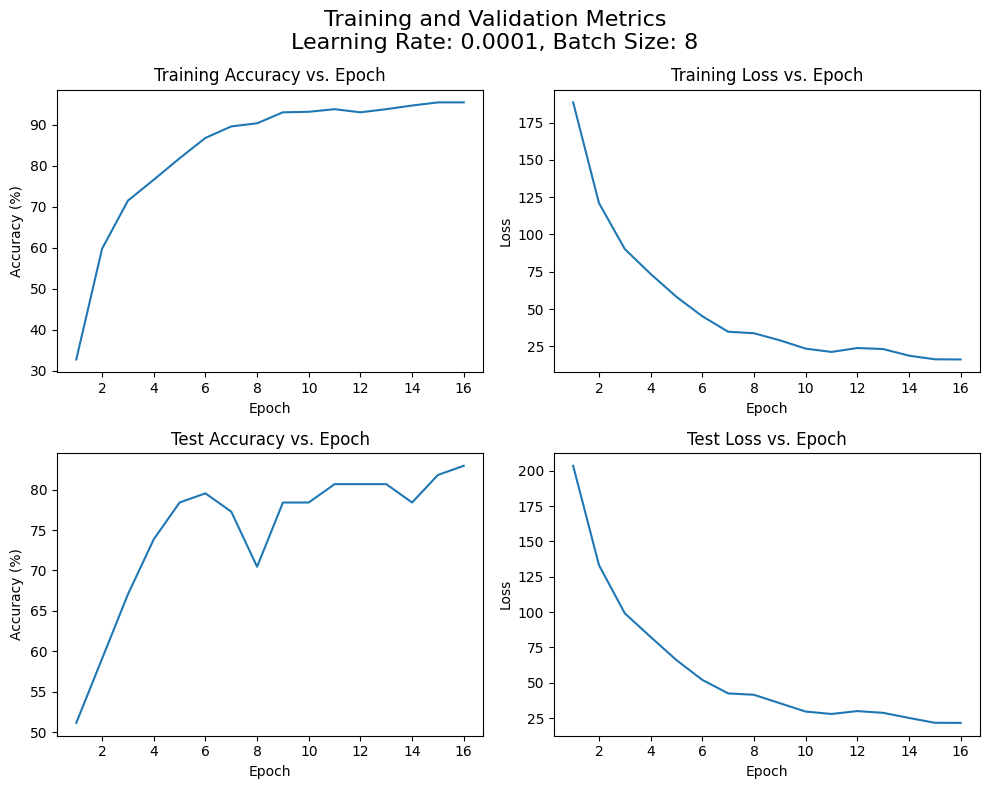

Finished Training
Final test accuracy = 82.95%
ResNet50 took 180.65156245231628 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.1327, Accuracy: 25.86%
Epoch 2/16, Loss: 1.3108, Accuracy: 57.32%
Epoch 3/16, Loss: 0.9590, Accuracy: 70.45%
Epoch 4/16, Loss: 0.7660, Accuracy: 77.83%
Epoch 5/16, Loss: 0.6410, Accuracy: 82.42%
Epoch 6/16, Loss: 0.4901, Accuracy: 86.62%
Epoch 7/16, Loss: 0.4224, Accuracy: 88.92%
Epoch 8/16, Loss: 0.3659, Accuracy: 90.96%
Epoch 9/16, Loss: 0.3048, Accuracy: 92.87%
Epoch 10/16, Loss: 0.3060, Accuracy: 94.27%
Epoch 11/16, Loss: 0.2667, Accuracy: 94.14%
Epoch 12/16, Loss: 0.2270, Accuracy: 94.90%
Epoch 13/16, Loss: 0.2110, Accuracy: 95.29%
Epoch 14/16, Loss: 0.1957, Accuracy: 95.80%
Epoch 15/16, Loss: 0.2203, Accuracy: 95.29%
Epoch 16/16, Loss: 0.1753, Accuracy: 95.92%


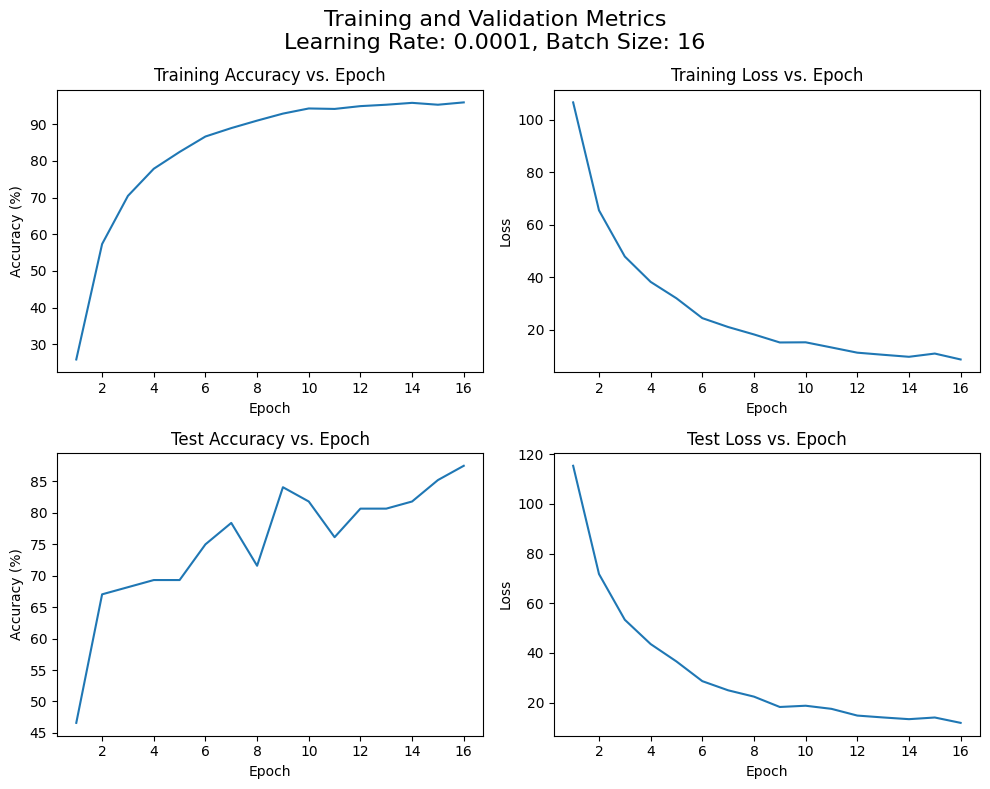

Finished Training
Final test accuracy = 87.50%
ResNet50 took 166.5886948108673 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 1.9715, Accuracy: 28.28%
Epoch 2/16, Loss: 1.5206, Accuracy: 49.55%
Epoch 3/16, Loss: 1.2357, Accuracy: 59.49%
Epoch 4/16, Loss: 1.0641, Accuracy: 65.48%
Epoch 5/16, Loss: 0.8995, Accuracy: 71.34%
Epoch 6/16, Loss: 0.7862, Accuracy: 73.89%
Epoch 7/16, Loss: 0.6863, Accuracy: 79.87%
Epoch 8/16, Loss: 0.6050, Accuracy: 80.64%
Epoch 9/16, Loss: 0.5787, Accuracy: 83.69%
Epoch 10/16, Loss: 0.4740, Accuracy: 86.11%
Epoch 11/16, Loss: 0.4283, Accuracy: 86.88%
Epoch 12/16, Loss: 0.4131, Accuracy: 86.62%
Epoch 13/16, Loss: 0.3923, Accuracy: 88.28%
Epoch 14/16, Loss: 0.3643, Accuracy: 90.06%
Epoch 15/16, Loss: 0.3432, Accuracy: 89.68%
Epoch 16/16, Loss: 0.2873, Accuracy: 92.23%


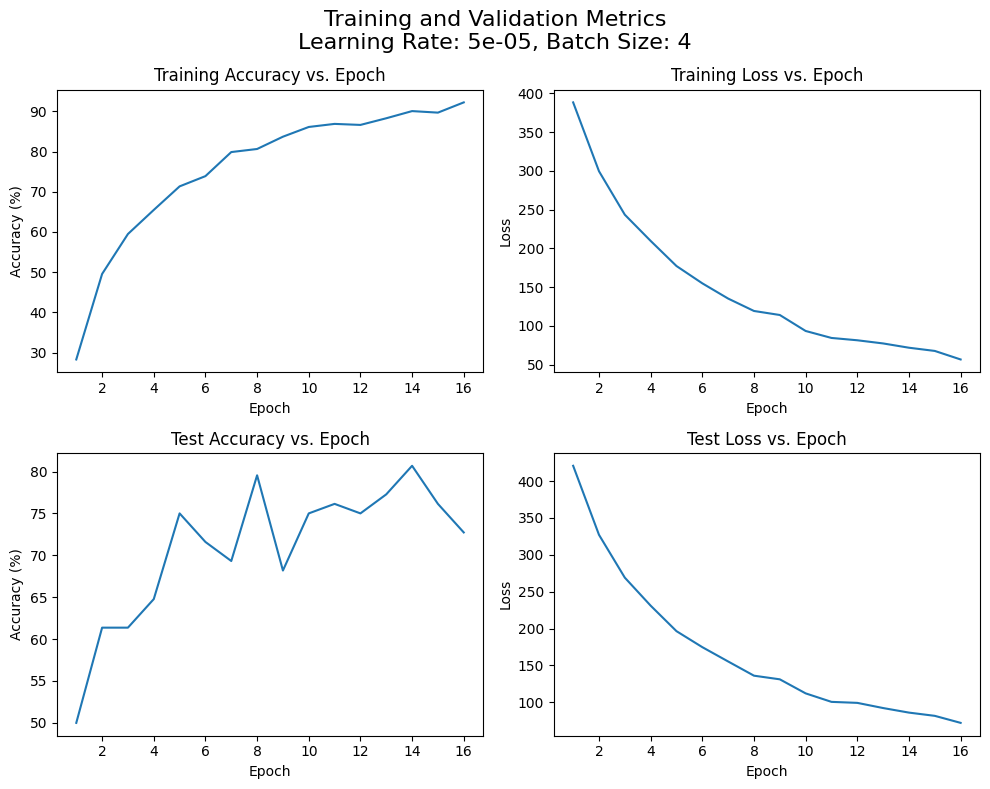

Finished Training
Final test accuracy = 72.73%
ResNet50 took 200.02453899383545 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.0707, Accuracy: 27.52%
Epoch 2/16, Loss: 1.5000, Accuracy: 50.45%
Epoch 3/16, Loss: 1.1520, Accuracy: 63.18%
Epoch 4/16, Loss: 0.9276, Accuracy: 72.10%
Epoch 5/16, Loss: 0.7432, Accuracy: 77.96%
Epoch 6/16, Loss: 0.6775, Accuracy: 79.75%
Epoch 7/16, Loss: 0.5940, Accuracy: 83.31%
Epoch 8/16, Loss: 0.4994, Accuracy: 86.75%
Epoch 9/16, Loss: 0.4758, Accuracy: 86.75%
Epoch 10/16, Loss: 0.3866, Accuracy: 89.81%
Epoch 11/16, Loss: 0.3647, Accuracy: 91.34%
Epoch 12/16, Loss: 0.3328, Accuracy: 91.21%
Epoch 13/16, Loss: 0.3439, Accuracy: 90.96%
Epoch 14/16, Loss: 0.2798, Accuracy: 92.74%
Epoch 15/16, Loss: 0.2606, Accuracy: 93.63%
Epoch 16/16, Loss: 0.2623, Accuracy: 93.12%


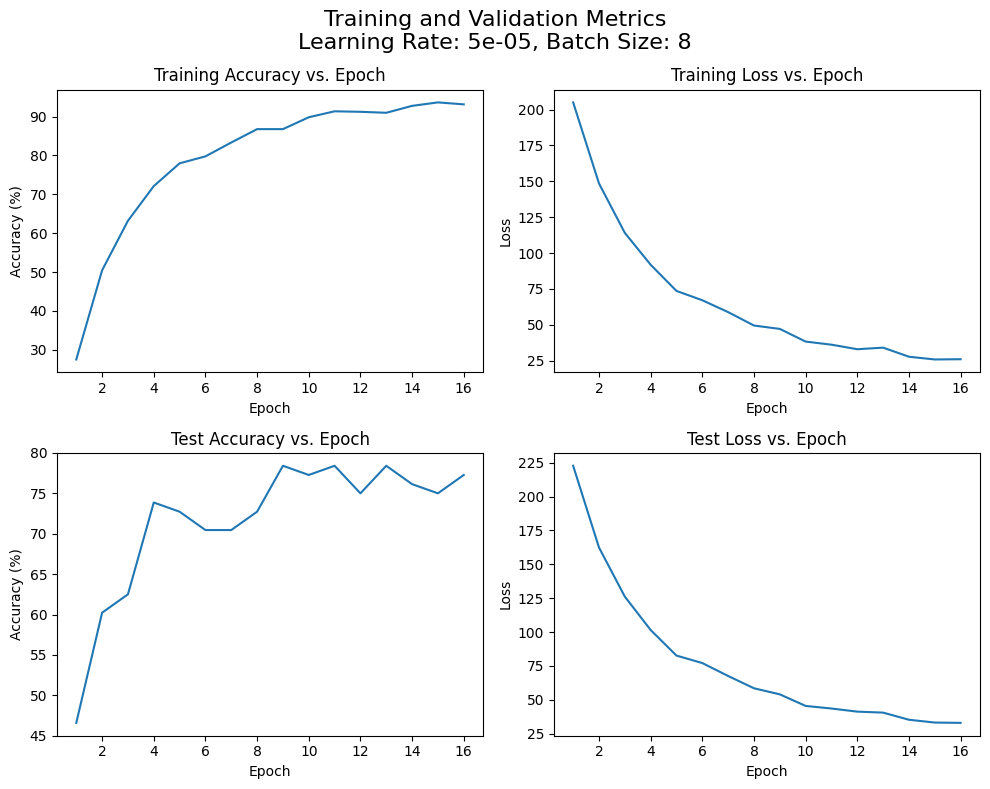

Finished Training
Final test accuracy = 77.27%
ResNet50 took 178.48276042938232 seconds to train


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch 1/16, Loss: 2.2390, Accuracy: 19.62%
Epoch 2/16, Loss: 1.6532, Accuracy: 46.11%
Epoch 3/16, Loss: 1.3418, Accuracy: 58.09%
Epoch 4/16, Loss: 1.1680, Accuracy: 65.99%
Epoch 5/16, Loss: 1.0129, Accuracy: 70.96%
Epoch 6/16, Loss: 0.8464, Accuracy: 77.58%
Epoch 7/16, Loss: 0.7874, Accuracy: 78.85%
Epoch 8/16, Loss: 0.6625, Accuracy: 84.08%
Epoch 9/16, Loss: 0.5687, Accuracy: 87.01%
Epoch 10/16, Loss: 0.5627, Accuracy: 86.88%
Epoch 11/16, Loss: 0.4828, Accuracy: 88.79%
Epoch 12/16, Loss: 0.4526, Accuracy: 89.68%
Epoch 13/16, Loss: 0.3924, Accuracy: 92.74%
Epoch 14/16, Loss: 0.3713, Accuracy: 91.85%
Epoch 15/16, Loss: 0.3649, Accuracy: 91.85%
Epoch 16/16, Loss: 0.3016, Accuracy: 93.50%


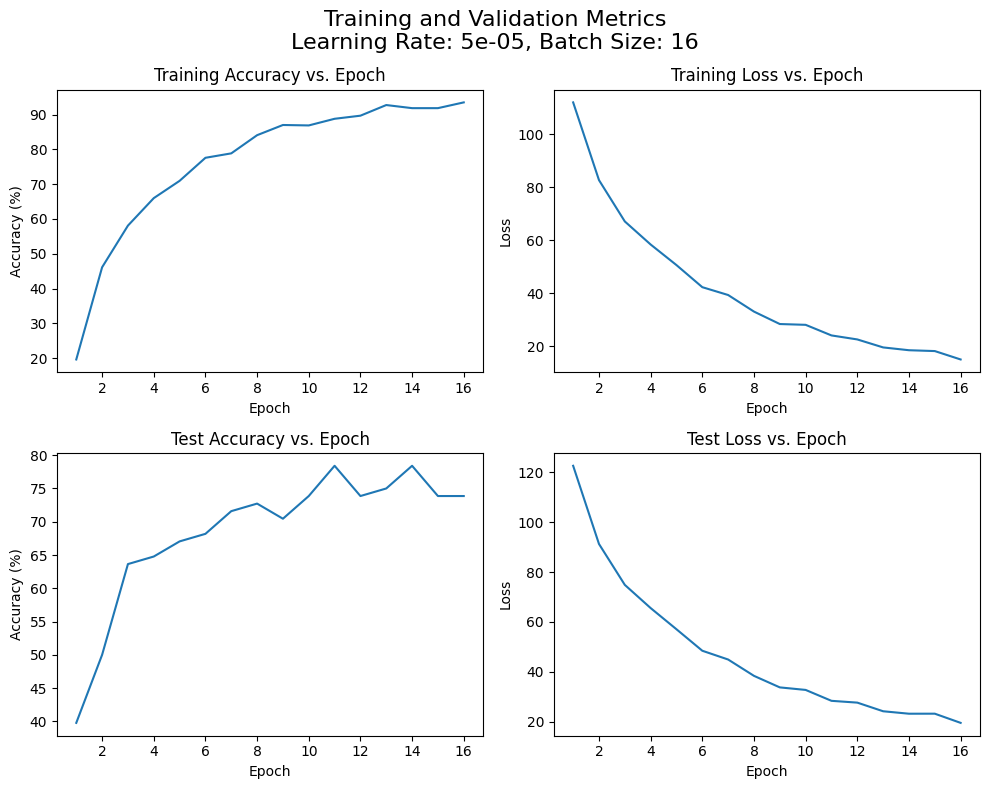

Finished Training
Final test accuracy = 73.86%
ResNet50 took 165.63591313362122 seconds to train


In [ ]:
# Further refinement grid search
num_epochs=16
LR = [0.001, 0.0005, 0.0001, 0.00005]
BS = [4, 8, 16]
criterion = nn.CrossEntropyLoss()


for lr in LR:
    for bs in BS:
        alexNetModel = models.alexnet(pretrained=True)
        alexNetModel = torch.nn.Sequential(
            alexNetModel,
            torch.nn.Linear(1000,10)
        )
        alexNetModel=alexNetModel.cuda()
        alexNetoptimizer = optim.SGD(alexNetModel.parameters(), lr=lr, momentum=0.9)
        alexnetTime = train_model(alexNetModel, alexNetoptimizer, criterion, num_epochs, batch_size = bs, learning_rate = lr)
        print(f"AlexNet took {alexnetTime} seconds to train")

for lr in LR:
    for bs in BS:
        resNet50Model = models.resnet50(pretrained=True)
        resNet50Model = torch.nn.Sequential(
            resNet50Model,
            torch.nn.Linear(1000,10)
        )
        resNet50Model=resNet50Model.cuda()
        resNet50optimizer = optim.SGD(resNet50Model.parameters(), lr=lr, momentum=0.9)
        resnetTime = train_model(resNet50Model, resNet50optimizer, criterion, num_epochs, batch_size = bs, learning_rate = lr)
        print(f"ResNet50 took {resnetTime} seconds to train")




/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing 

Epoch 1/16, Loss: 1.5220, Accuracy: 47.39%
Epoch 2/16, Loss: 0.7806, Accuracy: 76.18%
Epoch 3/16, Loss: 0.4564, Accuracy: 85.73%
Epoch 4/16, Loss: 0.3239, Accuracy: 89.17%
Epoch 5/16, Loss: 0.2635, Accuracy: 93.76%
Epoch 6/16, Loss: 0.2725, Accuracy: 92.87%
Epoch 7/16, Loss: 0.1933, Accuracy: 95.29%
Epoch 8/16, Loss: 0.2015, Accuracy: 95.03%
Epoch 9/16, Loss: 0.1290, Accuracy: 96.05%
Epoch 10/16, Loss: 0.1207, Accuracy: 96.05%
Epoch 11/16, Loss: 0.1778, Accuracy: 95.29%
Epoch 12/16, Loss: 0.1766, Accuracy: 95.92%
Epoch 13/16, Loss: 0.1554, Accuracy: 96.69%
Epoch 14/16, Loss: 0.1100, Accuracy: 96.69%
Epoch 15/16, Loss: 0.1365, Accuracy: 96.94%
Epoch 16/16, Loss: 0.1619, Accuracy: 95.80%


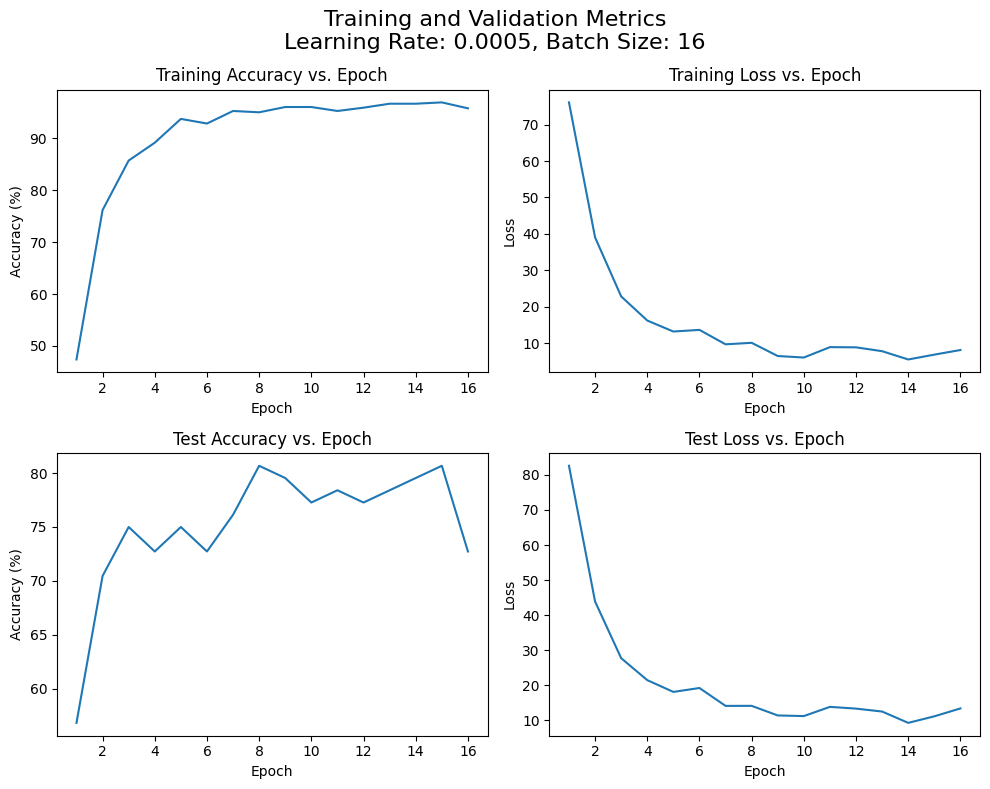

Finished Training
Final test accuracy = 72.73%
ResNet50 took 167.7479863166809 seconds to train


In [20]:
# Optimal model

train_dataset = CustomDataset(training_dir, csv_file, transform=transform)
train_dataset = [entry for entry in train_dataset if entry is not None]
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_dataset = CustomDataset(test_dir, csv_file, transform=transform)
test_dataset = [entry for entry in test_dataset if entry is not None]
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

resNet50Model = models.resnet50(pretrained=True)
resNet50Model = torch.nn.Sequential(
    resNet50Model,
    torch.nn.Linear(1000,10)
)
resNet50Model=resNet50Model.cuda()
resNet50optimizer = optim.SGD(resNet50Model.parameters(), lr=0.0005, momentum=0.9)
resnetTime = train_model(resNet50Model, resNet50optimizer, criterion, num_epochs, batch_size = 16, learning_rate = 0.0005)
print(f"ResNet50 took {resnetTime} seconds to train")



/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Test Accuracy: 76.14%
Overall Precision: 0.76


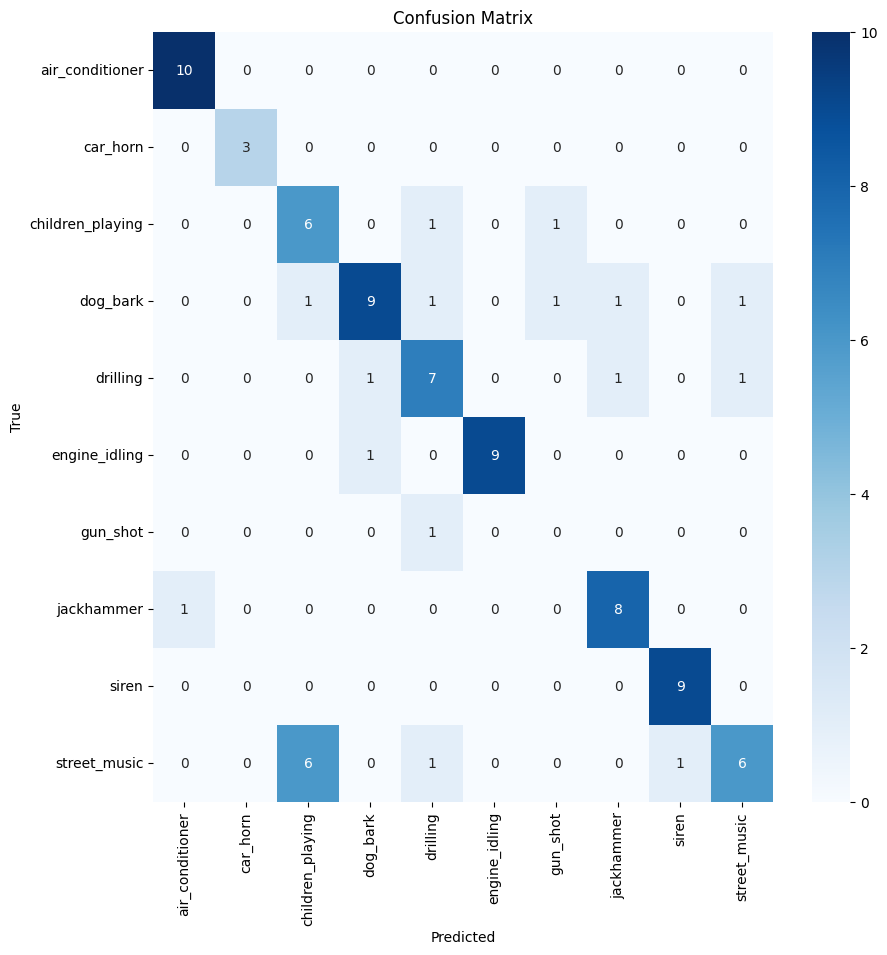

In [21]:
test_dataset = CustomDataset(test_dir, csv_file, transform=transform)
test_dataset = [entry for entry in test_dataset if entry is not None]
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

# Evaluate the model on the test set
resNet50Model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []
num_classes = 10  # Replace with the actual number of classes
true_positives = 0
false_positives = 0


with torch.no_grad():  # Disable gradient calculation during evaluation
    for inputs, labels in test_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = resNet50Model(inputs)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        true_positives += (predicted == 1).eq(labels == 1).sum().item()
        false_positives += (predicted == 1).eq(labels == 0).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

overall_precision = precision_score(all_labels, all_predictions, average='micro')
print(f'Overall Precision: {overall_precision:.2f}')

confusion = confusion_matrix(all_labels, all_predictions)

# Display the confusion matrix
plt.figure(figsize=(num_classes, num_classes))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping, yticklabels=label_mapping)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()